# Entanlgement aided transpilation of star qubit problems

Star qubit problems: 
Those problems that have a qubit who has many control operations onto other qubits. It is the "star" of the show!

Examples:
- Hadamard test phase extraction
- Error correction (shor)
- Entanglement preparation

Given that the above examples are used as subroutines or main-parts of many algorithms, we think this problem is of importance and of interest to optimize.

The star qubit is defined as the one that is "most connected" to other qubits.

## Approach

Given that a single qubit is central, we want to make it reachable to the rest of the system.

Solution is to prepare an entangled state which represents this "star qubit".

Given a hardware topology, we can find how to minimally distribute entangled qubits, such that every other qubit is directly coupled to an entangled qubit.

This enables each qubit to have a direct control operation by the "star" qubit.

This distribution of entangled qubits given a topology can be solved via "minimum dominating set" algorithms.

Once the entangled qubits are set, then you map an input circuit with the "star qubit" structure.

## Focus

For simplicity, we focus on Hadamard test phase extraction, using a set of random c-phase gates.

We test it on a naive approach without entanglement, and with entanglement.

We compare the errors to show that entanglement yields still correct results.

We then transpile the circuits using all available qubits.

The naive circuit is transpiled naiveley.

The entangled circuit is transpiled using a custom pipeline which considers the connectivity of the hardware.

We find a 50% improvement on output transpilation.

## Further explorations

### Identifying optimal star qubit via hyperparameter optimization

Superconducting qubits vary in quality across a chip, with some pairs yielding lower two-qubit gate error rates than others. We optimize “star”-shaped circuits by scoring each physical qubit based on connectivity, local CX error rates, and proximity to other qubits—then selecting the best as the circuit’s hub. The weighting of these score components is tuned using Optuna to minimize total CX error after transpilation.

### Metropolis optimizer of transpilation pipeline

In this part, we implement a metropolis algorithm to find a quasi-optimal pass manager pipeline for a given Quantum Circuit and Backend architecture. We start by proposing a random combination of pass manager options, and we then vary one of steps (initialization, layout, routing, synthesis). We accept the change only if the circuit depth is reduced in comparisson with the past configuration, or with a small probability if it increases the depth, so that we avoid local minima. We repeat this process for a given number of steps, and return the best pipeline that was found.

### GHZ preparation via binary trees

Use Binary Tree of CNOT gates to Construct a GHZ state and integrate this structure into the circuit.GHZ States and integrate it in our circuit.


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.approximation import min_weighted_dominating_set
import networkx as nx
import matplotlib.pyplot as plt
import math
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit_aer.backends import AerSimulator
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime.fake_provider import *


# Entanglement Optimized Transpilation

Backend and login

In [ ]:
backend = FakeTorino()

/var/folders/xr/9754bxf57zvg208710lnn4m80000gn/T/ipykernel_11841/150228845.py:3: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(channel="ibm_quantum",token=t)


Find dominating set for entanglement qubits

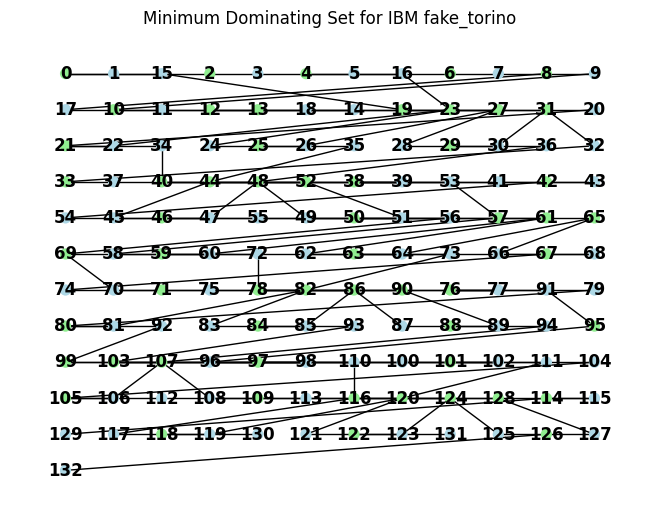

In [ ]:
coupling = backend.coupling_map

# Create a graph from the coupling map
G = nx.Graph()
G.add_edges_from(coupling)

# Square grid layout: arrange nodes in a square-ish grid
nodes = list(G.nodes)
n = len(nodes)
side = math.ceil(math.sqrt(n))  # side length of the square

# Assign grid positions
pos = nx.spring_layout(G, seed=2)

pos = {}
for i, node in enumerate(nodes):
    row = i // side
    col = i % side
    pos[node] = (col, -row)  # Flip Y to draw top-down


# Compute the minimum dominating set
dom_set = min_weighted_dominating_set(G)

# Visualize
colors = ['lightgreen' if n in dom_set else 'lightblue' for n in G.nodes]
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=50, font_weight='bold')
plt.title(f"Minimum Dominating Set for IBM {backend.name}")
plt.show()


Have list of sites for entanglement, and available free sites

In [ ]:
entangled_sites = list(dom_set)

nodes.sort()
entangled_sites.sort()

available_sites = []

for i in nodes:
    if i in entangled_sites:
        continue
    available_sites.append(i)


Have a map of how each non-dominating node is covered by entangled sites.
Coverage keys has the non-entangled sites, which can index the coverage map (i.e which entangled state connects to this non-entangled site)

In [ ]:
non_dominating_nodes = set(G.nodes) - dom_set

# Map each non-dominating node to the dominating neighbors that cover it
coverage_map = {}
for node in non_dominating_nodes:
    dominators = [neighbor for neighbor in G.neighbors(node) if neighbor in dom_set]
    coverage_map[node] = dominators

coverage_keys = list(coverage_map.keys())

Map a circuit such that aux is entangled

In [ ]:
def map_circuit_to_entangled(qc, backend, coverage_keys, coverage_map):
    # Sweep in execution (topological) order
    dag = circuit_to_dag(qc)

    new_circuit = QuantumCircuit(backend.num_qubits)

    # Loop all gates from CU gate
    for node in dag.topological_op_nodes():
        # Get indices of current node
        qubit_indices = [qc.find_bit(q).index for q in node.qargs]

        # Gate to apply
        gate = node.op

        # If two qubit gate
        if len(qubit_indices) == 2:
            control_q = qubit_indices[0]
            target_q = qubit_indices[1]

            # If 0, this is operating on an entangled site, choose closest
            if qubit_indices[0] == 0: 
                target_q = coverage_keys[qubit_indices[1]]
                control_q = coverage_map[target_q][0]
            if qubit_indices[1] == 0:
                target_q = coverage_keys[qubit_indices[0]]
                control_q = coverage_map[target_q][0]

            # Append gate
            qubit_indices = [control_q, target_q]
            new_circuit.append(gate, qubit_indices)

            continue
        
        # If it's a 1 qubit gate on an entangled site, apply to only first
        if qubit_indices[0] == 0:
            new_circuit.append(gate, [entangled_sites[0]])
            continue
        
        # Append other single qubit gates
        new_circuit.append(gate, [coverage_keys[qubit_indices[0]]])
    
    return new_circuit


In [ ]:
# Circuit that prepares a GHZ state across specific sites
def prepare_ghz(backend, entangled_sites):
    circuit = QuantumCircuit(backend.num_qubits)

    gen_1 = entangled_sites[0]
    gen_2 = entangled_sites[1]

    circuit.h(gen_1)
    circuit.cx(gen_1, gen_2)

    for i in range(1, len(entangled_sites) - 1):
        circuit.cx(entangled_sites[i], entangled_sites[i + 1])
    
    return circuit


In [ ]:
# Undoes GHZ state
def undo_ghz(backend, entangled_sites):
    circuit = QuantumCircuit(backend.num_qubits)

    gen_1 = entangled_sites[0]
    gen_2 = entangled_sites[1]

    for i in list(range(1, len(entangled_sites) - 1))[::-1]:
        circuit.cx(entangled_sites[i], entangled_sites[i + 1])
    circuit.cx(gen_1, gen_2)
    
    circuit.h(gen_1)

    return circuit

In [ ]:
# The CU circuit to be testing
def random_phase_circuit(n):
    circuit = QuantumCircuit(n)

    phase = 0
    for i in range(1, n):
        theta = np.random.uniform(0, np.pi)
        circuit.cp(theta, 0, i)
        phase += theta

    return circuit, phase

In [ ]:
simulator = AerSimulator()

Statistics to see if phase extraction works on entangled circuit

In [ ]:
M = 200
errors = []
N= 10

for m in range(M):
    # Unitary control circuit to extract phase fro
    phase_circ, phase = random_phase_circuit(N)
    trivial_qc = QuantumCircuit(N, 1)
    trivial_qc.x(range(1, N))
    trivial_qc = trivial_qc.compose(phase_circ)

    # Composition of circuits
    mapped_circuit = map_circuit_to_entangled(trivial_qc, backend, coverage_keys, coverage_map)
    ghz_circuit = prepare_ghz(backend, entangled_sites)
    undo_ghz_circuit = undo_ghz(backend, entangled_sites)

    entangled_qc = (
        QuantumCircuit(backend.num_qubits, len(entangled_sites)).compose(ghz_circuit).compose(mapped_circuit).compose(undo_ghz_circuit)
    )
        
    # Transpile and run
    main_site = entangled_sites[0]
    entangled_qc.measure(main_site, 0)
    qc_transpiled = transpile(entangled_qc)

    # Testing statistics correctness
    result = simulator.run(qc_transpiled, shots=1024*5).result()
    zeros = result.data()["counts"].get("0x0", 0)
    ones = result.data()["counts"].get("0x1", 0)
    total = zeros + ones

    p0 = zeros / total

    # We actually loose info on the phase, did not implement the full phase extraction from statistics, so dont' consider huge errors
    berry = 2 * np.arccos(np.sqrt(p0))
    phase_comparison = phase % (2 * np.pi)
    diff = np.abs(berry - phase_comparison)
    if diff > np.pi/2:
        diff = None
    
    errors.append(diff)

Text(0, 0.5, 'Abs error on phase extraction')

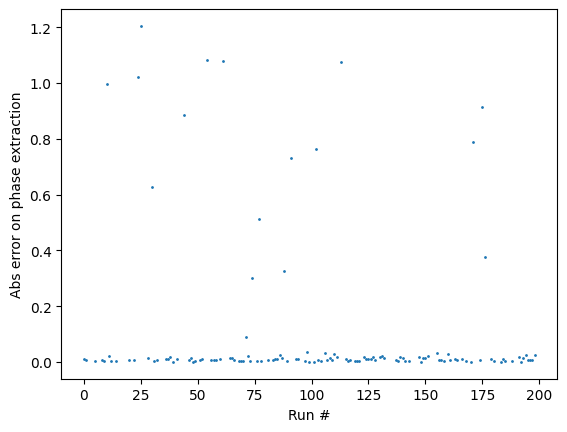

In [ ]:
plt.scatter(range(M), errors, s=1)
plt.xlabel('Run #')
plt.ylabel('Abs error on phase extraction')

Low enough average error :))
Now bellow do if for ALL available gates

In [ ]:
N = backend.num_qubits - len(entangled_sites)

phase_circ, phase = random_phase_circuit(N)

trivial_qc = QuantumCircuit(N, 1)
trivial_qc.x(range(1, N))
trivial_qc = trivial_qc.compose(phase_circ)

mapped_circuit = map_circuit_to_entangled(trivial_qc, backend, coverage_keys, coverage_map)
ghz_circuit = prepare_ghz(backend, entangled_sites)
undo_ghz_circuit = undo_ghz(backend, entangled_sites)

entangled_qc = (
    QuantumCircuit(backend.num_qubits, len(entangled_sites)).compose(ghz_circuit).compose(mapped_circuit).compose(undo_ghz_circuit)
)
    
main_site = entangled_sites[0]
entangled_qc.measure(main_site, 0)
qc_transpiled = transpile(entangled_qc)

Transpilation pipeline imports

In [ ]:
from qiskit.transpiler import  StagedPassManager, PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.common import generate_unroll_3q

# Transpiler Passes
## Layout passes
from qiskit.transpiler.passes.layout.vf2_layout import VF2Layout

## Routing passes
from qiskit.transpiler.passes.routing.star_prerouting import StarPreRouting

## Synthesis passes (passes for the translation stage)
from qiskit.transpiler.passes.synthesis.unitary_synthesis import UnitarySynthesis

## Optimization passes
from qiskit.transpiler.passes.optimization.collect_2q_blocks import Collect2qBlocks
from qiskit.transpiler.passes.optimization.consolidate_blocks import ConsolidateBlocks
from qiskit.transpiler.passes.optimization.commutative_cancellation import CommutativeCancellation

In [ ]:
def get_qc_characteristics(qc):
    depth = qc.depth()
    num_qubits = qc.num_qubits
    ops = qc.count_ops()
    num_multi_qubit_ops = qc.depth(lambda instr: len(instr.qubits) > 1)
    return {"depth": depth, "num_qubits": num_qubits, "ops": ops, "num_multi_qubit_ops": num_multi_qubit_ops}

In [ ]:
def print_qc_characteristics(qc):
    characteristics = get_qc_characteristics(qc)
    print("Quantum circuit characteristics")
    print("  Depth:", characteristics['depth'])
    print("  Number of qubits:", characteristics['num_qubits'])
    print("  Operations:", dict(characteristics['ops']))
    print("  Number of multi-qubit Operations:", characteristics['num_multi_qubit_ops'])

In [ ]:
# Hardware into account transpilation

cm = backend.coupling_map

pm_opt = StagedPassManager()
pm_opt.init = generate_unroll_3q(None)
pm_opt.layout = PassManager()
pm_opt.layout += VF2Layout(cm)
pm_opt.init += StarPreRouting()

pm_opt.translation =  PassManager(UnitarySynthesis())
pm_opt.translation += Collect2qBlocks()
pm_opt.translation += ConsolidateBlocks(basis_gates=backend.operation_names)
pm_opt.translation += UnitarySynthesis(backend.operation_names)

pm_opt.optimization = PassManager([
    CommutativeCancellation(),
    Collect2qBlocks(),
    ConsolidateBlocks(basis_gates=backend.operation_names),
    UnitarySynthesis(backend.operation_names)
])

# pm_opt.layout += generate_embed_passmanager(cm)

qc_opt = pm_opt.run(qc_transpiled)

In [ ]:
qk_qc = generate_preset_pass_manager(3, backend=backend).run(trivial_qc)

In [ ]:
print_qc_characteristics(qc_opt)
print_qc_characteristics(qk_qc)
reduction_ratio = round(100-100*(get_qc_characteristics(qc_opt)['num_multi_qubit_ops']/get_qc_characteristics(qk_qc)['num_multi_qubit_ops']), 3)
print("Reduction in two-qubit gates compared to qiskit {}%!".format(reduction_ratio))

Quantum circuit characteristics
  Depth: 577
  Number of qubits: 133
  Operations: {'sx': 918, 'rz': 779, 'cz': 359, 'x': 111, 'measure': 1}
  Number of multi-qubit Operations: 170
Quantum circuit characteristics
  Depth: 933
  Number of qubits: 133
  Operations: {'sx': 924, 'cz': 451, 'rz': 410, 'x': 3}
  Number of multi-qubit Operations: 347
Reduction in two-qubit gates compared to qiskit 51.009%!


Comparsion shows around 50% improvement!

# Identifying a Star Qubit

We build custom transpilation passes to identify and fix the star qubit, given a circuit and backend architecture.

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import Layout, PassManager, AnalysisPass, TransformationPass
from qiskit_ibm_runtime.fake_provider import *
from qiskit.dagcircuit import DAGCircuit
from rustworkx import distance_matrix
from collections import defaultdict, deque, Counter

class IdentifyVirtualStar(AnalysisPass):
  def __init__(self):
    super().__init__()

  def run(self, dag: DAGCircuit):
    counts = Counter()
    # Iterate all operation nodes in the DAG
    for node in dag.op_nodes():
      # Check for a 2-qubit instruction
      if node.num_qubits > 1:
        # Increment the counter for each qubit in that op
        counts.update(node.qargs)

    if not counts: # no multi-qubit gates
      return dag

    # Find the star and save it for later
    hub_qubit, max_count = counts.most_common(1)[0]
    self.property_set["virtual_hub"] = hub_qubit
    return dag

class IdentifyPhysicalStar(AnalysisPass):

  # hyperparameters alpha, beta, gamma
  def __init__(self, backend, alpha=9.8, beta=495, gamma=0.08, star_options=None):
    super().__init__()
    self.backend = backend
    self.alpha, self.beta, self.gamma = alpha, beta, gamma
    self.star_options = star_options

  @staticmethod
  def calculate_star_from_options(backend=FakeTorino(), alpha=9.8, beta=495, gamma=0.08, total_qubits=133, star_options=None):

    cmap = backend.coupling_map
    deg  = [len(cmap.neighbors(q)) for q in range(backend.num_qubits)]
    dmax = max(deg)

    props = backend.properties()
    cx_err = {q: 0.0 for q in range(backend.num_qubits)}
    if props:
      tmp = {q: [] for q in range(backend.num_qubits)}
      for g in props.gates:
        if g.gate[0] == "c":
          q1, q2 = g.qubits
          err = g.parameters[0].value
          tmp[q1].append(err); tmp[q2].append(err)
      cx_err = {q: (sum(v)/len(v) if v else 0.0) for q, v in tmp.items()}

    # pairwise distances (Floyd–Warshall)
    dist_mat = distance_matrix(cmap.graph)

    best_score, best_phys = float("inf"), None
    if star_options is None:
      star_options = range(total_qubits)
    for p in star_options:
      connectivity = alpha * (dmax - deg[p])
      gate_error = beta  * cx_err[p]
      proximity = gamma * sum(dist_mat[p][r] for r in range(total_qubits))
      score = connectivity + gate_error + proximity
      if score < best_score:
        best_score, best_phys = score, p
    return best_phys


  def run(self, dag: DAGCircuit):
    qubits = dag.qubits

    best_star = IdentifyPhysicalStar.calculate_star_from_options(backend=self.backend,
                                                                 alpha=self.alpha,
                                                                 beta=self.beta,
                                                                 gamma=self.gamma,
                                                                 total_qubits=len(qubits),
                                                                 star_options=self.star_options)
    
    self.property_set["best_star_qubit"] = best_star
    return dag


class PinBestStarQubit(TransformationPass):
  def __init__(self, backend):
    super().__init__()
    self.backend = backend

  def smart_complete_layout(self, dag, backend, virtual_hub, phys_hub):
    '''
    Build a full Layout that
      • keeps the star qubit fixed,
      • greedily maps every qubit that ever interacts with the hub
        onto the nearest still-free neighbour of phys_hub,
      • dumps any “left-over” qubits onto the remaining
        physical indices in order.
    '''
    cmap = backend.coupling_map
    phys_deg = {q: len(cmap.neighbors(q)) for q in range(backend.num_qubits)}

    partners = defaultdict(int)
    for node in dag.op_nodes():
      if len(node.qargs) == 2 and virtual_hub in node.qargs:
        other = node.qargs[0] if node.qargs[1] is virtual_hub else node.qargs[1]
        partners[other] += 1

    dist = distance_matrix(cmap.graph)

    lay = Layout({virtual_hub: phys_hub})
    used_phys = {phys_hub}

    # BFS starting from the star qubit
    queue = deque(sorted(cmap.neighbors(phys_hub),
                         key=lambda q: (dist[phys_hub][q], -phys_deg[q])))
    for vbit, _ in sorted(partners.items(), key=lambda kv: -kv[1]):  # busiest first
      if vbit in lay:
        continue
      while queue and queue[0] in used_phys:
        queue.popleft()
      if not queue:
        break
      pbit = queue.popleft()
      used_phys.add(pbit)
      lay[vbit] = pbit
      for ngh in cmap.neighbors(pbit):
        if ngh not in used_phys:
          queue.append(ngh)

    # map any still-unmapped logical qubits to remaining phys indices
    free_phys = [q for q in range(backend.num_qubits) if q not in used_phys]
    assert len(free_phys) == backend.num_qubits - len(lay)
    for vbit in dag.qubits:
      if vbit not in lay:
        lay[vbit] = free_phys.pop(0)

    return lay

  def run(self, dag):
    best_phys = self.property_set["best_star_qubit"]
    virtual_hub = self.property_set["virtual_hub"]

    full_layout = self.smart_complete_layout(
      dag,
      backend=self.backend,
      virtual_hub=virtual_hub,
      phys_hub=best_phys,
    )
    self.property_set["layout"] = full_layout
    return dag


The star qubit in the fake_torino backend is qubit 63.

We can also restrict the search space to a certain subset of qubits.

In [2]:
star_1 = IdentifyPhysicalStar.calculate_star_from_options(backend=FakeTorino(),
                                                       alpha=9.8,
                                                       beta=495,
                                                       gamma=0.08,
                                                       total_qubits=133,
                                                       star_options=None) # returns qubit 63
print(f"best star qubit: {star_1}")

star_2 = IdentifyPhysicalStar.calculate_star_from_options(backend=FakeTorino(),
                                                       alpha=9.8,
                                                       beta=495,
                                                       gamma=0.08,
                                                       total_qubits=133,
                                                       star_options=[i for i in range(133) if i != 63]) # returns the next best option after qubit 63
print(f"second best star qubit: {star_2}")

best star qubit: 63
second best star qubit: 65


Below is a sample workflow to transpile with the custom passes.

We use the custom passes to generate a custom layout, which we then pass along to qiskit's existing optimization steps.

In [3]:
# FakeTorino is the only large backend with error data
fake_backend = FakeTorino()

# make some circuit with a star qubit
n = fake_backend.num_qubits
qc = QuantumCircuit(n)
qc.h(0)
qc.cx(0, range(1,10))

pass_manager = PassManager([
  IdentifyVirtualStar(),
  IdentifyPhysicalStar(fake_backend),
  PinBestStarQubit(fake_backend),
])
pass_manager.run(qc)
layout = pass_manager.property_set["layout"]

transpiled = transpile(
        qc,
        backend=fake_backend,
        initial_layout=layout,
        optimization_level=2
    )

Identifying a star qubit relies on hyperparameters α, β, and γ.

We run an optimization loop to identify values which minimize overall gate error for the circuit.

In [4]:
import optuna


'''
    Ideally, the training loop would choose a
    random fake backend for each iteration, in
    order to improve training. However, many of
    these fake backends don't include gate-specific error
    rates. Thus, the decision was made to hardcode
    the FakeTorino backend in the training loop 
    as a proof of concept, as this backend does
    contain the requisite gate error rates.
'''
fake_backends = [
    FakeBrisbane(), 
    FakeCusco(), 
    FakeFez(), 
    FakeKawasaki(), 
    FakeKyiv(), 
    FakeKyoto(), 
    FakeMarrakesh(), 
    FakeOsaka(), 
    FakeQuebec(), 
    FakeSherbrooke(), 
    FakeTorino(), 
    FakeWashingtonV2()]

def compute_total_cx_error(circuit: QuantumCircuit, backend, transpiled):
  # Fetch backend properties
  props = backend.properties()
  cx_error_map = {}
  if props:
    for gate in props.gates:
      if gate.gate.lower()[0] == "c":
        q1, q2 = gate.qubits
        # gate.parameters includes a 'gate_error' entry
        err = next((p.value for p in gate.parameters if p.name == "gate_error"), None)
        if err is not None:
          cx_error_map[(q1, q2)] = err
          cx_error_map[(q2, q1)] = err  # symmetric

  
  total_success = 1.
  for inst, qargs, _ in transpiled.data:
    if inst.name[0] == 'c': # controlled operation
      qubit_pairs = (qc.qubits.index(qargs[0]), qc.qubits.index(qargs[1]))
      total_success *= 1-cx_error_map[qubit_pairs]
  return 1-total_success

def objective(trial):
    # Suggest hyperparameters
    alpha = trial.suggest_float("alpha", 0.0, 10.0)
    beta  = trial.suggest_float("beta", 0.0, 1000.0)
    gamma = trial.suggest_float("gamma", 0.0, 5.0)

    # choose backend (hardcoded FakeTorino for now, but ideally use np.random.choice)
    backend = FakeTorino()

    '''
        The influence of the "star" qubit by itself
        goes down as qubit distance goes up and physical
        gates require more and more connections with non-star
        qubits to achieve.
        Thus, make a "star" with ~10 qubits, so the physical
        circuit needs to go a couple qubits away from the
        star, but not too far.
    '''
    n = backend.num_qubits
    qc = QuantumCircuit(n)
    qc.h(0)
    qc.cx(0, range(1,10))

    # Build and run the custom transpiler pass pipeline
    pm = PassManager([
        IdentifyVirtualStar(),
        IdentifyPhysicalStar(backend, alpha=alpha, beta=beta, gamma=gamma),
        PinBestStarQubit(backend)
    ])
    # Run the analysis passes to obtain the layout
    pm.run(qc)
    layout = pm.property_set["layout"]

    # Transpile with the chosen layout
    transpiled = transpile(
        qc,
        backend=backend,
        initial_layout=layout,
        optimization_level=2
    )

    # Compute the total CX error as the trial’s loss
    total_error = compute_total_cx_error(qc, backend, transpiled)
    return total_error

# Create and run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best hyperparameters:")
print(study.best_params)

[I 2025-06-25 13:01:48,566] A new study created in memory with name: no-name-045c44f7-dc1c-468e-93cd-ac7d97047c3f
/var/folders/l9/4dxtptnx2h969j5w9xdj7y8h0000gn/T/ipykernel_17415/1892366539.py:44: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, _ in transpiled.data:
[I 2025-06-25 13:01:48,885] Trial 0 finished with value: 0.13771547734119827 and parameters: {'alpha': 3.9555613817404067, 'beta': 148.17397871809902, 'gamma': 3.572225144895068}. Best is trial 0 with value: 0.13771547734119827.
[I 2025-06-25 13:01:49,136] Trial 1 finished with value: 0.14749374095237644 and parameters: {'alpha': 4.209321337072019, 'beta': 907.9941968764182, 'gamma': 4.690517472699848}. Best is trial 0 with value: 0.13771547734119827.
[I 2025-06-25 13:01:49,434] Trial 2 finished with value: 0.1352174121678229 and parameters

Best hyperparameters:
{'alpha': 3.30159775154835, 'beta': 72.2514296361481, 'gamma': 2.656109473513423}


# Using Metropolis algorithm to find the optimal pass manager pipeline

In this part, we implement a metropolis algorithm to find a quasi-optimal pass manager pipeline for a given Quantum Circuit and Backend architecture. We start by proposing a random combination of pass manager options, and we then vary one of steps (initialization, layout, routing, synthesis). We accept the change only if the circuit depth is reduced in comparisson with the past configuration, or with a small probability if it increases the depth, so that we avoid local minima. We repeat this process for a given number of steps, and return the best pipeline that was found.

In [1]:
import random
import math
from qiskit.compiler import transpile
from qiskit import QuantumCircuit
from qiskit.transpiler import PassManager, CouplingMap
from qiskit.transpiler.passes import *
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
# transpiler passes
from qiskit.transpiler.passes.layout import csp_layout, dense_layout, sabre_layout, vf2_layout, trivial_layout
# Routing pa″sses
from qiskit.transpiler.passes.routing import basic_swap, lookahead_swap, sabre_swap, stochastic_swap
from qiskit.transpiler.passes.routing import star_prerouting
# Synthesis passes (passes for the translation stage)
from qiskit.circuit import SessionEquivalenceLibrary
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.transpiler.passes.basis import basis_translator
from qiskit.transpiler.passes.synthesis import unitary_synthesis, high_level_synthesis
# Optimization passes
from qiskit.transpiler.passes.optimization import commutative_cancellation, consolidate_blocks, collect_2q_blocks, collect_1q_runs

In [2]:
import random
import math
import time
import hashlib
import pickle
from qiskit import QuantumCircuit
from qiskit.transpiler import PassManager, CouplingMap
from qiskit.transpiler.passes import *
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary

class MetropolisPassManager:
    def __init__(self, backend, num_steps=50, initial_temp=10.0, cooling_rate=0.95, 
                 cache_path="transpilation_cache.pkl", use_cache=True):
        self.backend = backend
        config = backend.configuration()
        
        # Convert coupling_map to CouplingMap object
        coupling_map = config.coupling_map
        self.coupling_map = CouplingMap(coupling_map) if coupling_map else None
        
        # Define fields
        self.basis_gates = config.basis_gates
        self.properties = backend.properties()
        self.num_qubits = config.n_qubits
        self.num_steps = num_steps
        self.temp = initial_temp
        self.cooling_rate = cooling_rate
        self.use_cache = use_cache
        self.cache_path = cache_path
        
        # Initialize cache
        self.cache = self._load_cache()
        
        # Define pass options for each stage
        self.pass_options = {
            'init': self._init_options(),
            'layout': self._layout_options(),
            'routing': self._routing_options(),
            'synthesis': self._synthesis_options()
        }
    
    # Load cache to speed up process
    def _load_cache(self):
        """Load cache from file if it exists"""
        if not self.use_cache:
            return {}
        try:
            with open(self.cache_path, 'rb') as f:
                return pickle.load(f)
        except (FileNotFoundError, EOFError):
            return {}
    
    # Save cache
    def _save_cache(self):
        """Save cache to file"""
        if self.use_cache:
            with open(self.cache_path, 'wb') as f:
                pickle.dump(self.cache, f)
    
    def _get_config_signature(self, config):
        """Generate unique signature for a configuration"""
        return hashlib.sha256(pickle.dumps(config)).hexdigest()
    
    def _get_circuit_signature(self, circuit):
        """Generate unique signature for a circuit"""
        return hashlib.sha256(pickle.dumps(circuit)).hexdigest()
    
    def _init_options(self):
        """Options for initial decomposition stage"""
        return [
            [Unroll3qOrMore(), BasisTranslator(SessionEquivalenceLibrary, self.basis_gates)],
            [BasisTranslator(SessionEquivalenceLibrary, self.basis_gates)],
            [HighLevelSynthesis(), UnrollCustomDefinitions(SessionEquivalenceLibrary), 
             BasisTranslator(SessionEquivalenceLibrary, self.basis_gates)]
        ]
    
    def _layout_options(self):
        """Qubit mapping"""
        return [
            # Option 1: Trivial layout with manual layout setting
            [SetLayout(self._trivial_layout), FullAncillaAllocation(self.coupling_map), 
             EnlargeWithAncilla(), ApplyLayout()]
        ]
    
    def _trivial_layout(self, dag):
        """Create a trivial layout for the circuit"""
        from qiskit.transpiler import Layout
        return Layout.generate_trivial_layout(*dag.qregs.values())
    
    def _routing_options(self):
        """Routing options for coupling constraints"""
        return [
            [BasicSwap(self.coupling_map)],
            [LookaheadSwap(self.coupling_map)],
            [StochasticSwap(self.coupling_map)],
            [SabreSwap(self.coupling_map)]
        ]
    
    def _synthesis_options(self):
        """Final optimization options"""
        return [
            [Optimize1qGates(), CXCancellation()],
            [CommutativeCancellation(), Optimize1qGates()],
            [TemplateOptimization(), Collect2qBlocks(), ConsolidateBlocks()]
        ]
    
    def _random_config(self):
        """Generate random configuration of passes"""
        return {
            'init': random.randint(0, len(self.pass_options['init']) - 1),
            'layout': random.randint(0, len(self.pass_options['layout']) - 1),
            'routing': random.randint(0, len(self.pass_options['routing']) - 1),
            'synthesis': random.randint(0, len(self.pass_options['synthesis']) - 1)
        }
    
    def _get_pass_list(self, config):
        """Get pass list from config indices"""
        return {
            stage: self.pass_options[stage][index]
            for stage, index in config.items()
        }
    
    def _mutate_config(self, config):
        """Create neighbor configuration by modifying one stage"""
        new_config = config.copy()
        stage = random.choice(list(self.pass_options.keys()))
        new_config[stage] = random.randint(0, len(self.pass_options[stage]) - 1)
        return new_config
    
    def _build_pass_manager(self, config):
        """Construct PassManager from configuration"""
        pass_list = self._get_pass_list(config)
        pm = PassManager()
        for stage in ['init', 'layout', 'routing', 'synthesis']:
            for pass_ in pass_list[stage]:
                pm.append(pass_)
        return pm
    
    def _cost_function(self, circuit):
        """Evaluate circuit quality (lower is better)"""
        cx_count = circuit.count_ops().get('cx', 0)
        return circuit.depth() + 0.5 * cx_count
    
    def _transpile_with_cache(self, circuit, config):
        """Transpile with caching support"""
        circuit_sig = self._get_circuit_signature(circuit)
        config_sig = self._get_config_signature(config)
        cache_key = f"{circuit_sig}_{config_sig}"
        
        # Check cache
        if self.use_cache and cache_key in self.cache:
            return self.cache[cache_key]
        
        # Not in cache - transpile and cache result
        pm = self._build_pass_manager(config)
        try:
            transpiled = pm.run(circuit)
            cost = self._cost_function(transpiled)
            result = (transpiled, cost)
        except Exception as e:
            # Mark as invalid
            result = (None, float('inf'))
        
        if self.use_cache:
            self.cache[cache_key] = result
            self._save_cache()
        
        return result
    
    def run(self, circuit):
        """Optimize using Metropolis algorithm"""
        # Initial random configuration
        current_config = None
        current_circuit = circuit
        current_cost = float('inf')
        
        # Find a valid initial configuration
        max_attempts = 20
        for _ in range(max_attempts):
            config = self._random_config()
            transpiled, cost = self._transpile_with_cache(circuit, config)
            if cost < float('inf'):
                current_config = config
                current_circuit = transpiled
                current_cost = cost
                break
        
        if current_config is None:
            # Fallback if no valid configuration found
            current_config = self._random_config()
            current_cost = self._cost_function(circuit)
        
        best_config = current_config
        best_circuit = current_circuit
        best_cost = current_cost
        
        # Optimization loop
        for step in range(self.num_steps):
            # Generate neighbor configuration
            new_config = self._mutate_config(current_config) # Mutate current config
            # Transpile updated circuit and evaluate cost function
            new_circuit, new_cost = self._transpile_with_cache(circuit, new_config)
            
            # Skip invalid configurations
            if new_cost == float('inf'):
                continue
            
            # Calculate cost difference
            delta_cost = new_cost - current_cost
            
            # Acceptance probability (Metropolis criterion)
            if delta_cost < 0 or random.random() < math.exp(-delta_cost / self.temp):
                current_config = new_config
                current_circuit = new_circuit
                current_cost = new_cost
                
                # Update best solution found
                if new_cost < best_cost:
                    best_config = new_config
                    best_circuit = new_circuit
                    best_cost = new_cost
            
            # Cool down temperature
            self.temp *= self.cooling_rate
        
        return best_circuit

## Trying the pass manager on a 133 GHZ state preparation circuit

In this part, we use the Metropolis pass manager to transpile a 133 GHZ state preparation circuit and then verify if the transpiled circuit is equivalent to the initial circuit

In [3]:
from qiskit_ibm_runtime.fake_provider import FakeTorino

# Create test circuit
qc = QuantumCircuit(133)
for i in range(132):
    qc.cx(0, i+1)
qc.measure_all()

# Initialize optimizer
backend = FakeTorino()
optimizer = MetropolisPassManager(backend, num_steps=30)

# Run optimization
optimized_qc = optimizer.run(qc)

print(f"Original depth: {transpile(qc, backend, optimization_level=3).depth()}")
print(f"Optimized depth: {optimized_qc.depth()}")

Original depth: 1172
Optimized depth: 133


### Verify both circuits are equivalent using MQT

In [4]:
%pip install mqt.qcec
from mqt.qcec import verify

result = verify(qc, optimized_qc)
print(result.equivalence)


equivalent


## Benchmarking

For this process we generate random circuits with different depths and number of qubits, and then transpile these circuits using the Qiskit default transpiler (with optimization level set to 3), and our custom Metropolis transpiler. We compare depth and runtime.


Benchmarking circuit 1/10: 58 qubits, 98 depth
  Default: depth=63, time=0.41s
  Custom:  depth=9, time=0.21s
  Improvement: depth=+54

Benchmarking circuit 2/10: 39 qubits, 41 depth
  Default: depth=9, time=0.14s
  Custom:  depth=5, time=0.23s
  Improvement: depth=+4

Benchmarking circuit 3/10: 55 qubits, 32 depth
  Default: depth=7, time=0.13s
  Custom:  depth=4, time=0.22s
  Improvement: depth=+3

Benchmarking circuit 4/10: 50 qubits, 41 depth
  Default: depth=41, time=0.17s
  Custom:  depth=5, time=0.20s
  Improvement: depth=+36

Benchmarking circuit 5/10: 32 qubits, 25 depth
  Default: depth=9, time=0.14s
  Custom:  depth=3, time=0.21s
  Improvement: depth=+6

Benchmarking circuit 6/10: 79 qubits, 86 depth
  Default: depth=133, time=0.39s
  Custom:  depth=11, time=0.28s
  Improvement: depth=+122

Benchmarking circuit 7/10: 20 qubits, 87 depth
  Default: depth=147, time=0.17s
  Custom:  depth=17, time=0.22s
  Improvement: depth=+130

Benchmarking circuit 8/10: 71 qubits, 54 depth


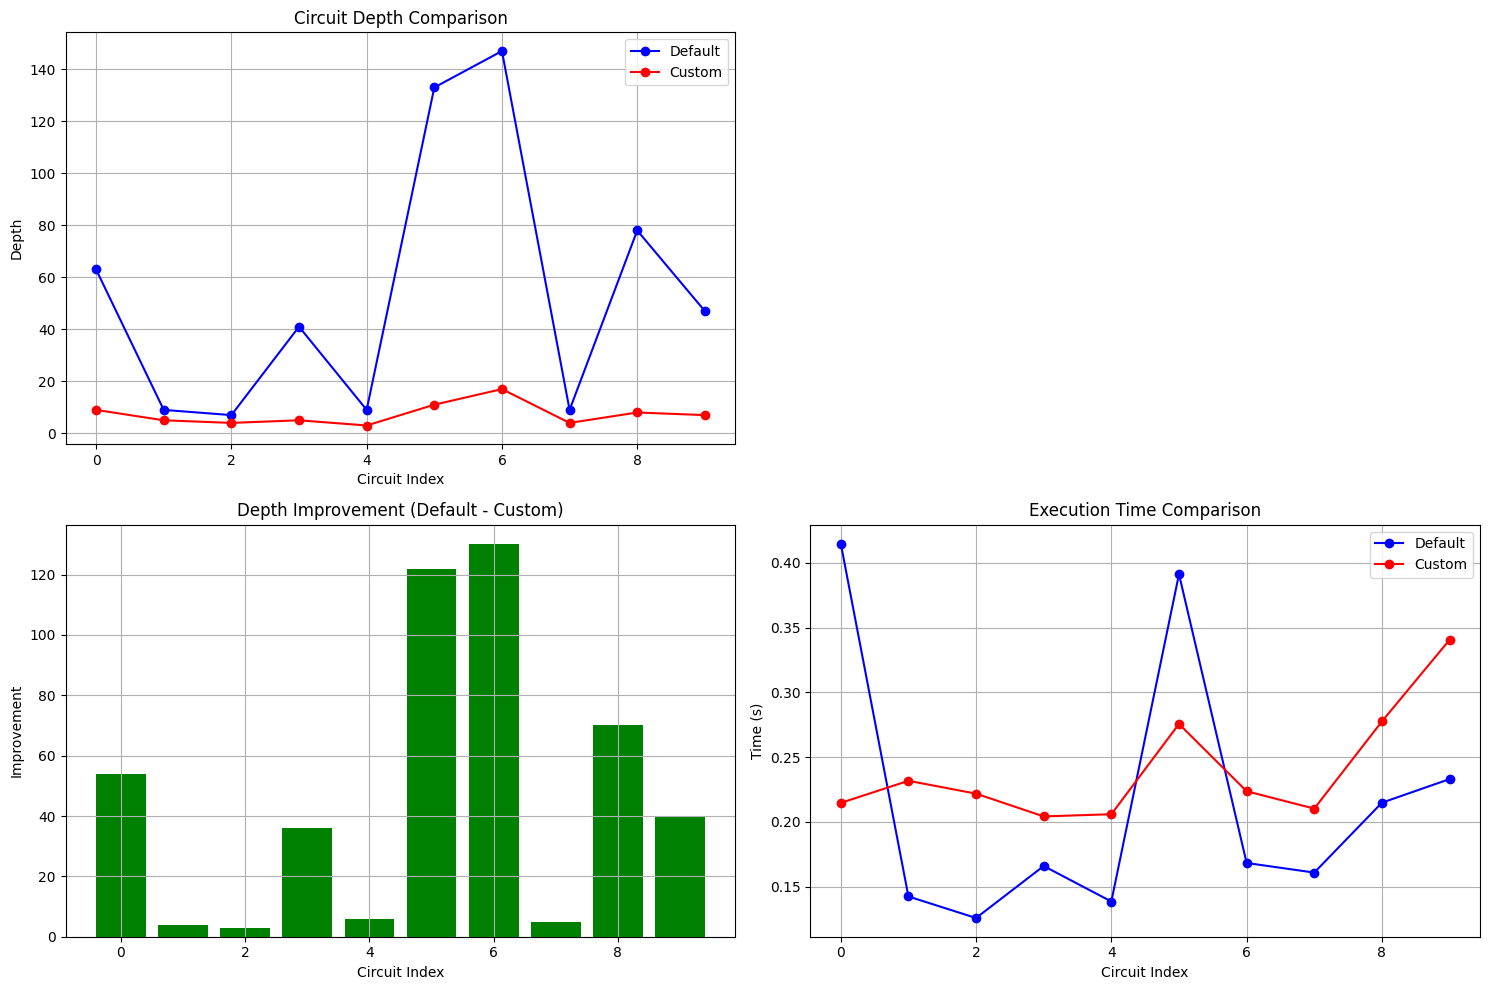


Final Summary:
Average Depth Improvement: 47.00
Average Default Time: 0.22s
Average Custom Time: 0.24s
Speed Ratio: 1.12x


In [5]:
import matplotlib.pyplot as plt
import time
import numpy as np

from qiskit import QuantumCircuit
from qiskit.circuit.library import XGate, YGate, ZGate, HGate, CXGate, CZGate, RXGate, RYGate, RZGate
import random

def generate_random_circuit(num_qubits, depth, max_operands=2, measure=False):
    """
    Generate a random quantum circuit.
    
    :param num_qubits: Number of qubits in the circuit
    :param depth: Number of layers of gates
    :param max_operands: Maximum number of qubits a gate can act on (1 or 2)
    :param measure: Whether to add measurement gates at the end
    :return: A QuantumCircuit object
    """
    qc = QuantumCircuit(num_qubits)

    # Define available gates
    one_qubit_gates = [XGate(), YGate(), ZGate(), HGate(), RXGate(random.uniform(0, 2*np.pi)),
                       RYGate(random.uniform(0, 2*np.pi)), RZGate(random.uniform(0, 2*np.pi))]
    two_qubit_gates = [CXGate(), CZGate()]

    for _ in range(depth):
        gate_type = random.randint(1, max_operands)

        if gate_type == 1 or num_qubits == 1:
            q = random.randint(0, num_qubits - 1)
            gate = random.choice(one_qubit_gates)
            qc.append(gate, [q])
        else:
            q1, q2 = random.sample(range(num_qubits), 2)
            gate = random.choice(two_qubit_gates)
            qc.append(gate, [q1, q2])

    if measure:
        qc.measure_all()

    return qc


def benchmark_transpilers(backend, num_circuits=10, min_qubits=3, max_qubits=10, min_depth=10, max_depth=50):
    """
    Benchmark MetropolisPassManager against default transpiler
    :param backend: Target backend
    :param num_circuits: Number of test circuits
    :param min_qubits: Minimum circuit width
    :param max_qubits: Maximum circuit width
    :param min_depth: Minimum circuit depth
    :param max_depth: Maximum circuit depth
    """
    # Initialize pass manager
    custom_pm = MetropolisPassManager(backend, num_steps=30)
    
    # Results storage
    results = {
        'circuit_sizes': [],
        'default_depths': [],
        'custom_depths': [],
        'default_cx_counts': [],
        'custom_cx_counts': [],
        'default_times': [],
        'custom_times': [],
        'depth_improvements': [],
        'cx_improvements': []
    }
    
    for i in range(num_circuits):
        # Generate random circuit
        num_qubits = random.randint(min_qubits, max_qubits)
        depth = random.randint(min_depth, max_depth)
        circuit = generate_random_circuit(num_qubits, depth)
        
        # Store circuit size info
        results['circuit_sizes'].append((num_qubits, depth))
        
        print(f"\nBenchmarking circuit {i+1}/{num_circuits}: {num_qubits} qubits, {depth} depth")
        
        # Run default transpiler
        start_time = time.time()
        default_transpiled = transpile(circuit, backend=backend)
        default_time = time.time() - start_time
        
        # Run custom transpiler
        start_time = time.time()
        custom_transpiled = custom_pm.run(circuit)
        custom_time = time.time() - start_time
        
        # Calculate metrics
        default_depth = default_transpiled.depth()
        custom_depth = custom_transpiled.depth()
                
        # Store results
        results['default_depths'].append(default_depth)
        results['custom_depths'].append(custom_depth)
        results['default_times'].append(default_time)
        results['custom_times'].append(custom_time)
        results['depth_improvements'].append(default_depth - custom_depth)

        print(f"  Default: depth={default_depth}, time={default_time:.2f}s")
        print(f"  Custom:  depth={custom_depth}, time={custom_time:.2f}s")
        print(f"  Improvement: depth={default_depth - custom_depth:+}")
    return results

def analyze_results(results):
    """Analyze and visualize benchmarking results"""
    # Calculate averages
    avg_depth_improvement = np.mean(results['depth_improvements'])
    avg_time_default = np.mean(results['default_times'])
    avg_time_custom = np.mean(results['custom_times'])
    
    print("\n" + "="*50)
    print("Benchmark Summary:")
    print(f"Average Depth Improvement: {avg_depth_improvement:.2f}")
    print(f"Average Default Transpiler Time: {avg_time_default:.2f}s")
    print(f"Average Custom Transpiler Time: {avg_time_custom:.2f}s")
    print("="*50)
    
    # Create plots
    plt.figure(figsize=(15, 10))
    
    # Depth comparison
    plt.subplot(2, 2, 1)
    plt.plot(results['default_depths'], 'bo-', label='Default')
    plt.plot(results['custom_depths'], 'ro-', label='Custom')
    plt.title('Circuit Depth Comparison')
    plt.xlabel('Circuit Index')
    plt.ylabel('Depth')
    plt.legend()
    plt.grid(True)
    
    # CX count comparison
    
    # Improvements
    plt.subplot(2, 2, 3)
    plt.bar(range(len(results['depth_improvements'])), results['depth_improvements'], color='g')
    plt.title('Depth Improvement (Default - Custom)')
    plt.xlabel('Circuit Index')
    plt.ylabel('Improvement')
    plt.grid(True)
    
    # Execution time comparison
    plt.subplot(2, 2, 4)
    plt.plot(results['default_times'], 'bo-', label='Default')
    plt.plot(results['custom_times'], 'ro-', label='Custom')
    plt.title('Execution Time Comparison')
    plt.xlabel('Circuit Index')
    plt.ylabel('Time (s)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('transpiler_benchmark.png')
    plt.show()
    
    # Return summary
    return {
        'avg_depth_improvement': avg_depth_improvement,
        'avg_time_default': avg_time_default,
        'avg_time_custom': avg_time_custom
    }

# Main benchmarking execution
if __name__ == "__main__":
    backend = FakeTorino()
    
    # Run benchmark with 10 circuits of varying sizes
    results = benchmark_transpilers(
        backend,
        num_circuits=10,
        min_qubits=10,
        max_qubits=100,
        min_depth=20,
        max_depth=100
    )
    
    # Analyze and visualize results
    summary = analyze_results(results)
    
    # Print final summary
    print("\nFinal Summary:")
    print(f"Average Depth Improvement: {summary['avg_depth_improvement']:.2f}")
    print(f"Average Default Time: {summary['avg_time_default']:.2f}s")
    print(f"Average Custom Time: {summary['avg_time_custom']:.2f}s")
    print(f"Speed Ratio: {summary['avg_time_custom']/summary['avg_time_default']:.2f}x")

# Further Ideas: GHZ Preparation via Binary Tree

Use Binary Tree of CNOT gates to Construct a GHZ state and integrate this structure into the circuit.GHZ States and integrate it in our circuit.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.approximation import min_weighted_dominating_set
from networkx.algorithms.approximation import min_weighted_dominating_set
import networkx as nx
import matplotlib.pyplot as plt
import math
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit.random import random_circuit
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit_aer.backends import AerSimulator
import numpy as np
from qiskit import QuantumCircuit, transpile

Backend and login

In [ ]:

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibm_brisbane")

C:\Users\jknem\AppData\Local\Temp\ipykernel_21008\1680457023.py:2: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(channel="ibm_quantum")


Find dominating set for entanglement qubits

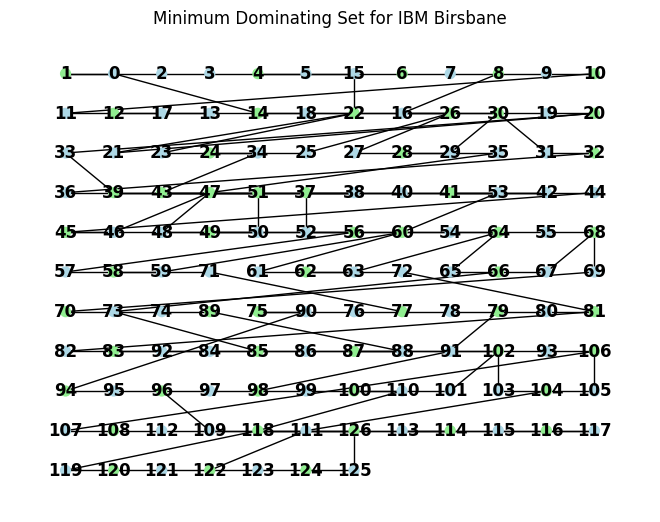

In [ ]:
coupling = backend.coupling_map

# Create a graph from the coupling map
G = nx.Graph()
G.add_edges_from(coupling)

# Square grid layout: arrange nodes in a square-ish grid
nodes = list(G.nodes)
n = len(nodes)
side = math.ceil(math.sqrt(n))  # side length of the square

# Assign grid positions
pos = nx.spring_layout(G, seed=2)

pos = {}
for i, node in enumerate(nodes):
    row = i // side
    col = i % side
    pos[node] = (col, -row)  # Flip Y to draw top-down


# Compute the minimum dominating set
dom_set = min_weighted_dominating_set(G)

# Visualize
colors = ['lightgreen' if n in dom_set else 'lightblue' for n in G.nodes]
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=50, font_weight='bold')
plt.title("Minimum Dominating Set for IBM Birsbane")
plt.show()


Have list of sites for entanglement, and available free sites

In [ ]:
entangled_sites = list(dom_set)

nodes.sort()
entangled_sites.sort()

available_sites = []

for i in nodes:
    if i in entangled_sites:
        continue
    available_sites.append(i)


Have a map of how each non-dominating node is covered by entangled sites.
Coverage keys has the non-entangled sites, which can index the coverage map (i.e which entangled state connects to this non-entangled site)

In [ ]:
non_dominating_nodes = set(G.nodes) - dom_set

# Map each non-dominating node to the dominating neighbors that cover it
coverage_map = {}
for node in non_dominating_nodes:
    dominators = [neighbor for neighbor in G.neighbors(node) if neighbor in dom_set]
    coverage_map[node] = dominators

coverage_keys = list(coverage_map.keys())

Map a circuit such that aux is entangled

In [ ]:
def map_circuit_to_entangled(qc, backend, coverage_keys, coverage_map):
    # Sweep in execution (topological) order
    dag = circuit_to_dag(qc)

    new_circuit = QuantumCircuit(backend.num_qubits)

    # Loop all gates from CU gate
    for node in dag.topological_op_nodes():
        # Get indices of current node
        qubit_indices = [qc.find_bit(q).index for q in node.qargs]

        # Gate to apply
        gate = node.op

        # If two qubit gate
        if len(qubit_indices) == 2:
            control_q = qubit_indices[0]
            target_q = qubit_indices[1]

            # If 0, this is operating on an entangled site, choose closest
            if qubit_indices[0] == 0: 
                target_q = coverage_keys[qubit_indices[1]]
                control_q = coverage_map[target_q][0]
            if qubit_indices[1] == 0:
                target_q = coverage_keys[qubit_indices[0]]
                control_q = coverage_map[target_q][0]

            # Append gate
            qubit_indices = [control_q, target_q]
            new_circuit.append(gate, qubit_indices)

            continue
        
        # If it's a 1 qubit gate on an entangled site, apply to only first
        if qubit_indices[0] == 0:
            new_circuit.append(gate, [entangled_sites[0]])
            continue
        
        # Append other single qubit gates
        new_circuit.append(gate, [coverage_keys[qubit_indices[0]]])
    
    return new_circuit


In [ ]:
def prepare_ghz(backend, entangled_sites):
    circuit = QuantumCircuit(backend.num_qubits)

    gen_1 = entangled_sites[0]
    gen_2 = entangled_sites[1]

    circuit.h(gen_1)
    circuit.cx(gen_1, gen_2)

    for i in range(1, len(entangled_sites) - 1):
        circuit.cx(entangled_sites[i], entangled_sites[i + 1])
    
    return circuit


In [ ]:
def undo_ghz(backend, entangled_sites):
    circuit = QuantumCircuit(backend.num_qubits)

    gen_1 = entangled_sites[0]
    gen_2 = entangled_sites[1]

    for i in list(range(1, len(entangled_sites) - 1))[::-1]:
        circuit.cx(entangled_sites[i], entangled_sites[i + 1])
    circuit.cx(gen_1, gen_2)
    
    circuit.h(gen_1)

    return circuit

In [ ]:
def random_phase_circuit(n):
    circuit = QuantumCircuit(n + 1)

    phase = 0
    for i in range(1, n + 1):
        theta = np.random.uniform(0, np.pi)
        circuit.cp(theta, 0, i)
        phase += theta

    return circuit, phase

In [ ]:
simulator = AerSimulator()

In [ ]:
backend.num_qubits

127

In [ ]:
phase_circ, phase = random_phase_circuit(4)

qc = QuantumCircuit(5, 1)
qc.x(range(1, 5))
qc = qc.compose(phase_circ)

mapped_circuit = map_circuit_to_entangled(qc, backend, coverage_keys, coverage_map)

entangled_circuit = prepare_ghz(backend, entangled_sites)
undo_entanglement_circuit = undo_ghz(backend, entangled_sites)

final_qc_with_prepare_ghz = (
    QuantumCircuit(127, len(entangled_sites)).compose(entangled_circuit).compose(mapped_circuit).compose(undo_entanglement_circuit)
)
    
main_site = entangled_sites[0]
final_qc_with_prepare_ghz.measure(main_site, 0)



In [ ]:
final_qc_with_prepare_ghz.depth()

107

In [ ]:
qc_transpiled = transpile(final_qc_with_prepare_ghz)

In [ ]:
qc_transpiled.depth()

9

In [ ]:
result = simulator.run(qc_transpiled, shots=1024*10).result()
zeros = result.data()["counts"].get("0x0", 0)
ones = result.data()["counts"].get("0x1", 0)
total = zeros + ones

p0 = zeros / total

berry = 2 * np.arccos(np.sqrt(p0))

print(berry)
print(phase % (2 * np.pi))

2.1819688531635757
2.179985645100306


In [ ]:
def binary_tree(n):
    qc = QuantumCircuit(n)
    qc.h(0)

    # Queue-basierte Breitensuche für binären Baum
    queue = [0]
    next_qubit = 1

    while next_qubit < n:
        parent = queue.pop(0)

        # Linkes Kind
        if next_qubit < n:
            qc.cx(parent, next_qubit)
            queue.append(next_qubit)
            next_qubit += 1

        # Rechtes Kind
        if next_qubit < n:
            qc.cx(parent, next_qubit)
            queue.append(next_qubit)
            next_qubit += 1

    return qc

In [ ]:
qc = QuantumCircuit(5, 1)
qc.x(range(1, 5))
qc = qc.compose(phase_circ)

mapped_circuit = map_circuit_to_entangled(qc, backend, coverage_keys, coverage_map)

# Replace GHZ part with binary tree entanglement
ghz_tree = binary_tree(len(entangled_sites))

entangled_circuit = QuantumCircuit(127)
entangled_circuit = entangled_circuit.compose(ghz_tree, qubits=entangled_sites)

undo_entanglement_circuit = QuantumCircuit(127)
undo_entanglement_circuit = undo_entanglement_circuit.compose(ghz_tree.inverse(), qubits=entangled_sites)


final_qc = (
    QuantumCircuit(127, len(entangled_sites)).compose(entangled_circuit).compose(mapped_circuit).compose(undo_entanglement_circuit)
)
    
main_site = entangled_sites[0]
final_qc.measure(main_site, 0)



In [ ]:
final_qc.depth()

21

In [ ]:
qc_transpiled_2 = transpile(final_qc)

In [ ]:
qc_transpiled_2.depth()

8

In [ ]:
result = simulator.run(qc_transpiled_2, shots=1024*10).result()
zeros = result.data()["counts"].get("0x0", 0)
ones = result.data()["counts"].get("0x1", 0)
total = zeros + ones

p0 = zeros / total

berry = 2 * np.arccos(np.sqrt(p0))

print(berry)
print(phase % (2 * np.pi))

2.177207101464795
2.179985645100306


# Inspiration

### Literature


"Childs, A. M., Cleve, R., Deotto, E., Farhi, E., Gutmann, S., & Spielman, D. A. (2003, June). Exponential algorithmic speedup by a quantum walk. In Proceedings of the thirty-fifth annual ACM symposium on Theory of computing (pp. 59-68)."

"Babbush, R., Berry, D. W., Kothari, R., Somma, R. D., & Wiebe, N. (2023). Exponential quantum speedup in simulating coupled classical oscillators. Physical Review X, 13(4), 041041."

### Run GHZ State

In [ ]:
# Import necessary modules for this notebook
import qiskit
import time
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_state_qsphere
from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
print(qiskit.__version__)

2.1.0


In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

In [ ]:
# Load saved credentials
service = QiskitRuntimeService()

C:\Users\jknem\AppData\Local\Temp\ipykernel_19616\3551195330.py:2: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


In [ ]:
service = QiskitRuntimeService()
backend = service.backend('ibm_brisbane')


C:\Users\jknem\AppData\Local\Temp\ipykernel_19616\2214418707.py:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


In [ ]:
seed_sim=42
backend=AerSimulator.from_backend(backend,seed_simulator=seed_sim)


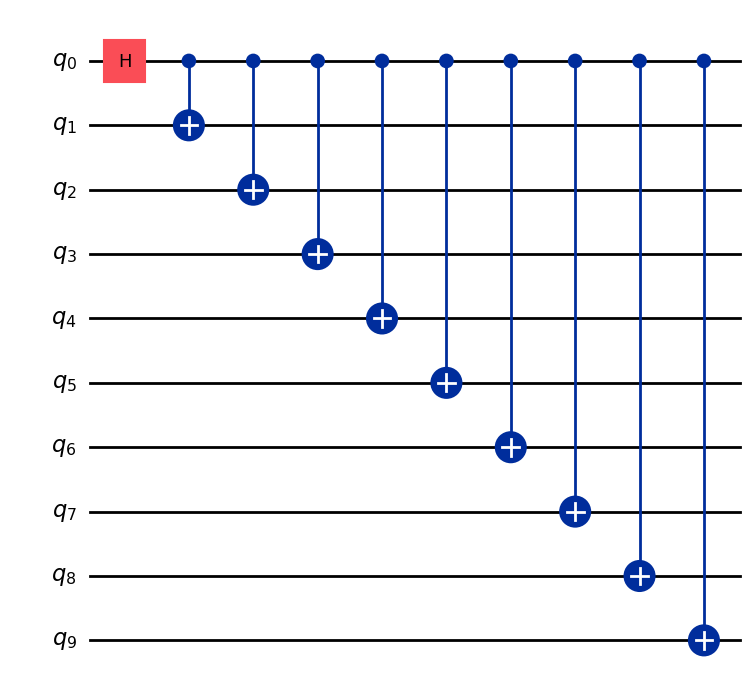

In [ ]:
def circuit(n):
    
    qc = QuantumCircuit(n)
    qc.h(0)  # Hadamard-Gatter auf Qubit 0 (Zentrum)

    for i in range(1, n):
        qc.cx(0, i)  # CNOT von Qubit 0 zu jedem anderen Qubit

    return qc

qc = circuit(10)

qc.draw('mpl')

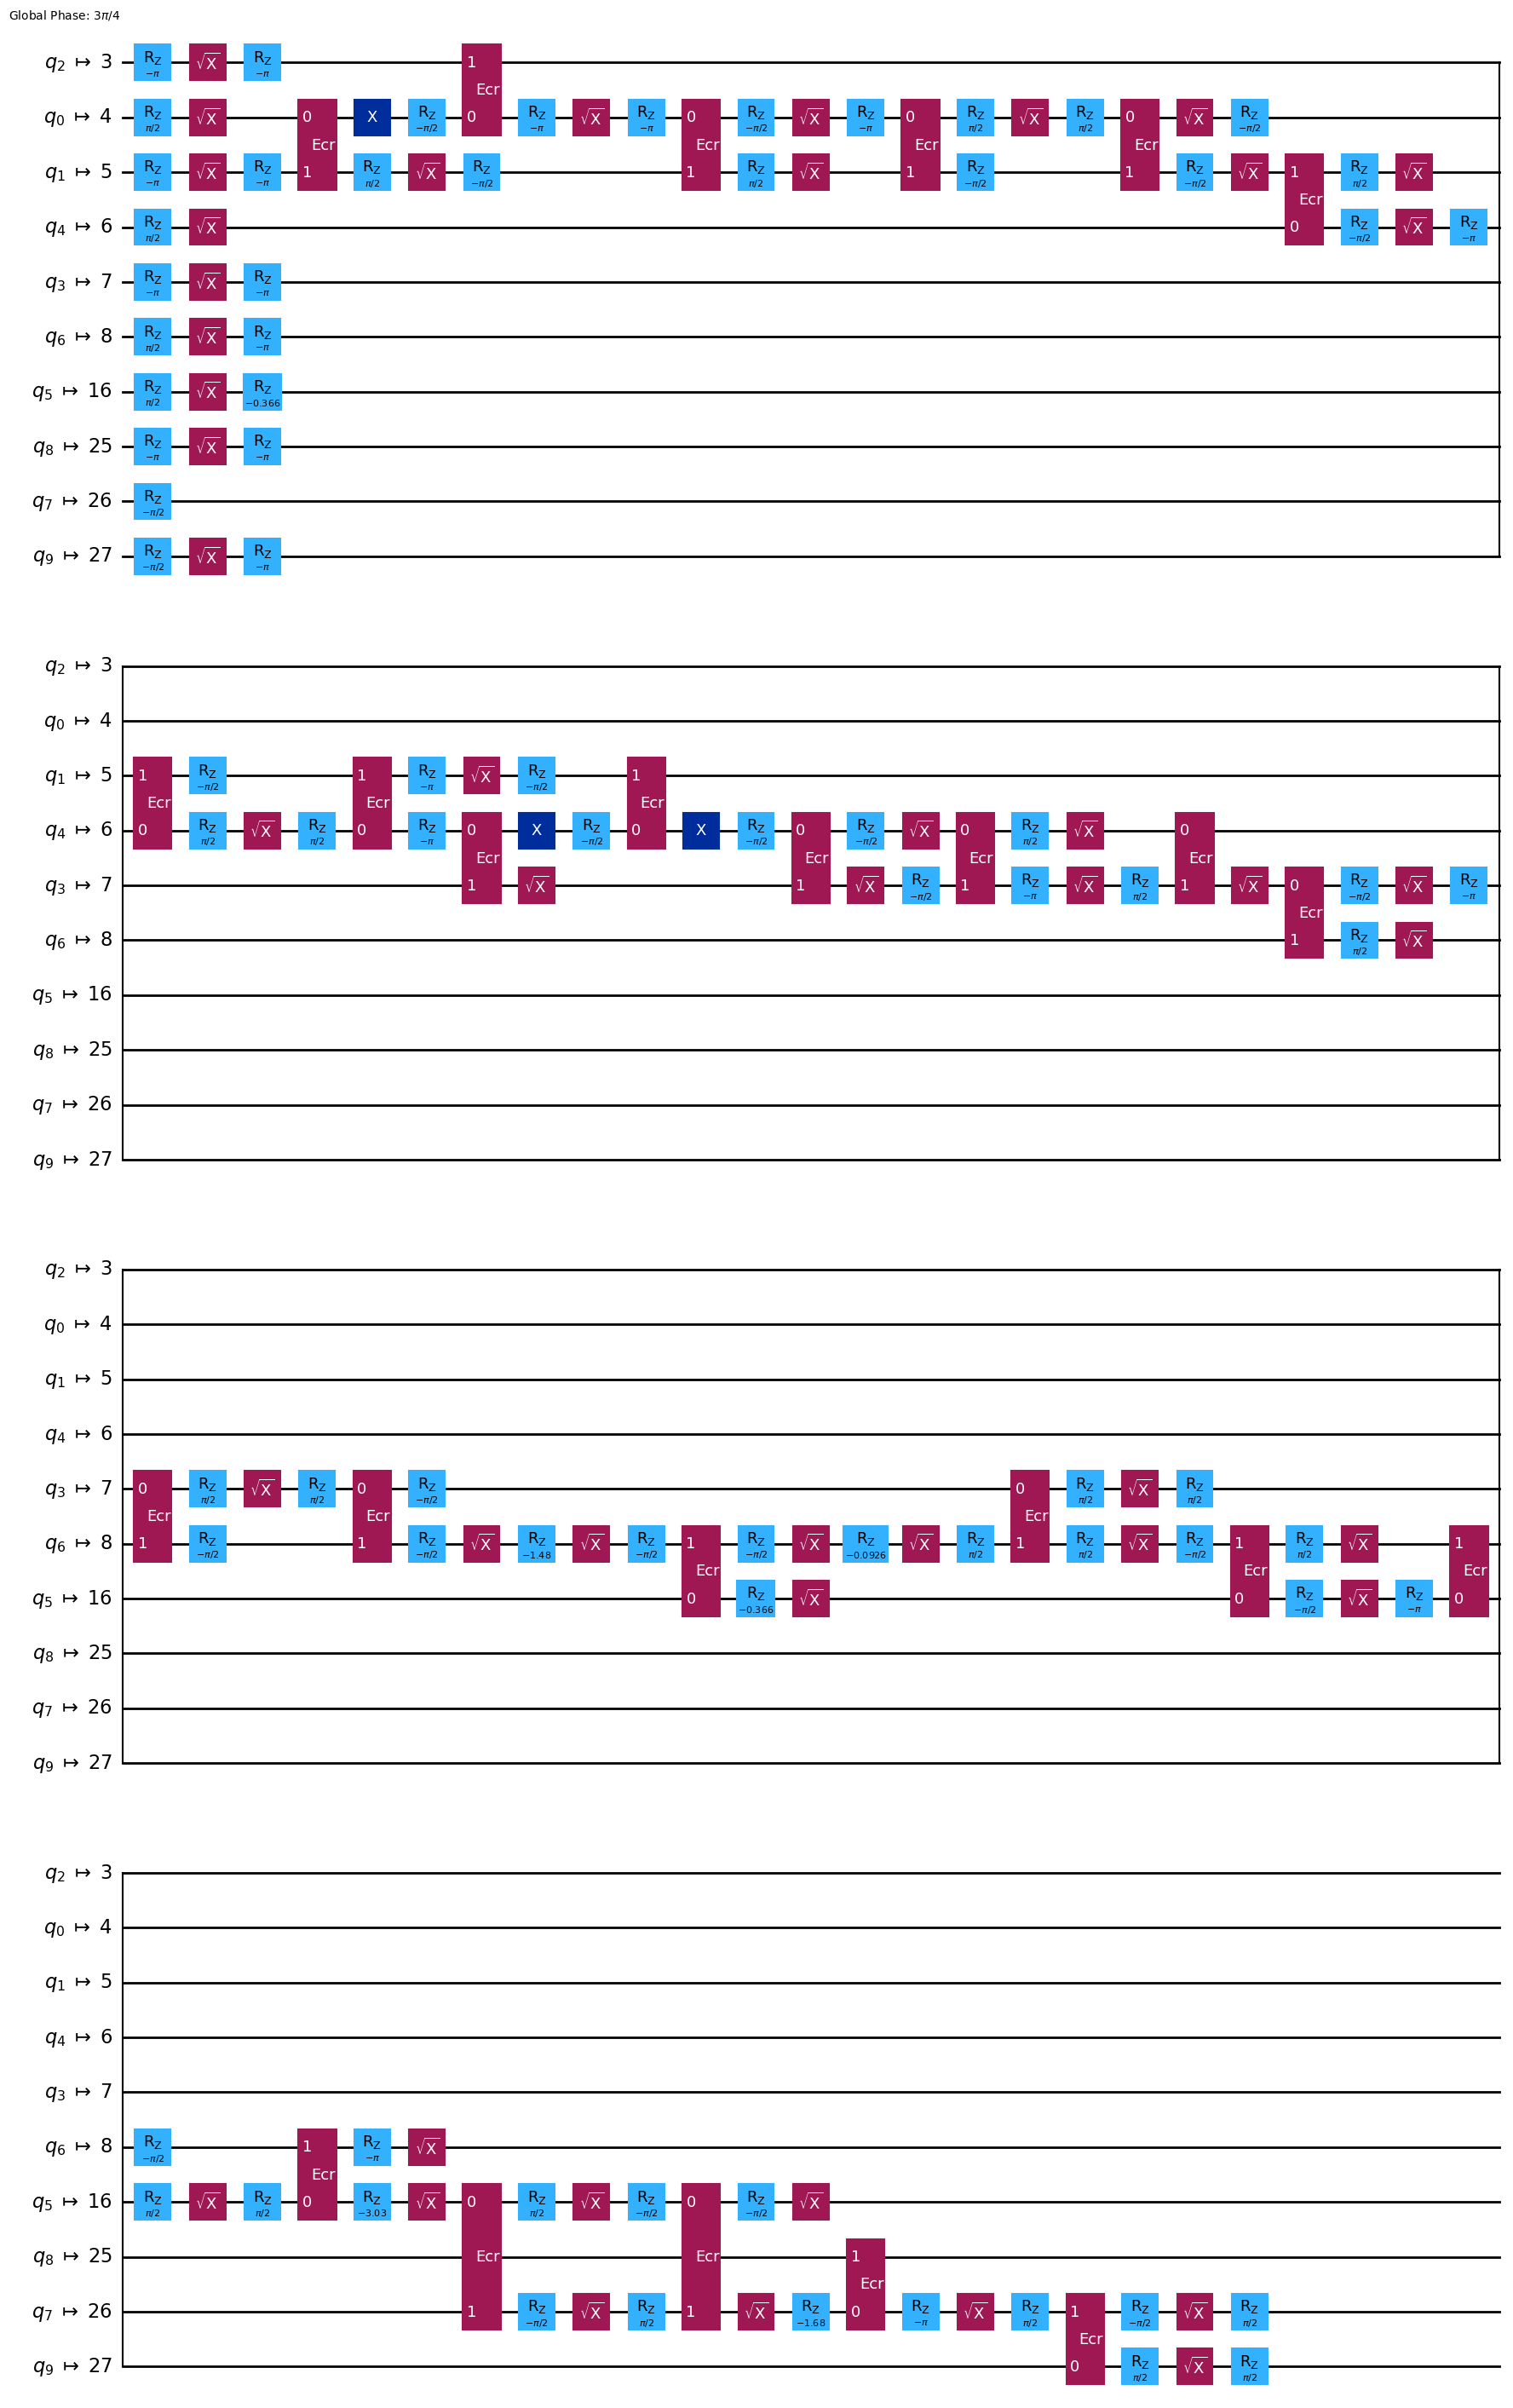

In [ ]:


pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
isa_circuit = pm.run(qc)


isa_circuit.draw("mpl", idle_wires=False)

In [ ]:
n = 10

observables_labels= ["Z" + "I" * i + "Z" + "I" * (n - i - 2) for i in range(n - 1)
    
]

print(observables_labels)
print(len(observables_labels))

observables = [SparsePauliOp(operator) for operator in observables_labels]

['ZZIIIIIIII', 'ZIZIIIIIII', 'ZIIZIIIIII', 'ZIIIZIIIII', 'ZIIIIZIIII', 'ZIIIIIZIII', 'ZIIIIIIZII', 'ZIIIIIIIZI', 'ZIIIIIIIIZ']
9


In [ ]:

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

In [ ]:

job = estimator.run([(isa_circuit, mapped_observables)])

print(f">>> Job ID: {job.job_id()}")

>>> Job ID: 997d142a-a0fb-4d86-9224-6592ca6edc49


c:\Users\jknem\Anaconda3\envs\qiskit_env_2\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


After a job is submitted, you can wait until either the job is completed within your current python instance, or use the `job_id` to retrieve the data at a later time.  (See the [section on retrieving jobs](https://docs.quantum.ibm.com/guides/monitor-job#retrieve-job-results-at-a-later-time) for details.)

After the job completes, examine its output through the job's `result()` attribute.



In [ ]:

job_result = job.result()

pub_result = job.result()[0]

Now we can also execute the circuit using the `Sampler` primitive

In [ ]:

qc.measure_all()
sampler = Sampler(mode=backend)

In [ ]:
job_sampler = sampler.run(pm.run([qc]))

print(f">>> Job ID: {job_sampler.job_id()}")

results_sampler = job_sampler.result()

>>> Job ID: 7aee52eb-18b3-448c-9623-bb2a75bf3210


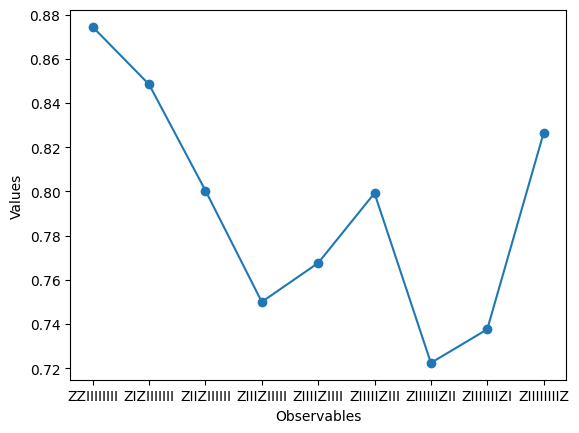

In [ ]:
# Plot the result
from matplotlib import pyplot as plt
values = pub_result.data.evs
errors = pub_result.data.stds
# plotting graph
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

{'0111111110': 5, '1111111111': 369, '0000000000': 368, '0100000000': 8, '0001111110': 2, '0000001000': 16, '1111111110': 9, '1101111111': 11, '1111110111': 6, '1110111111': 32, '1111110101': 7, '1011111111': 11, '1110100000': 1, '0010000000': 10, '0000000100': 9, '0000010000': 4, '0001000000': 19, '1111101111': 9, '0001000010': 1, '1111111101': 15, '0000100000': 12, '1111100001': 4, '0000001010': 6, '0000000001': 6, '1111011111': 3, '1111011110': 2, '1001000001': 1, '0110100001': 1, '0000110000': 1, '1111000001': 1, '1111111011': 5, '1000000001': 6, '0010110000': 1, '0111110111': 1, '0000000010': 2, '1110011111': 1, '0000011110': 1, '1001000000': 1, '1111101011': 1, '1000000000': 5, '0010100000': 1, '0100100000': 1, '0111111111': 8, '0101111101': 1, '0000000110': 3, '1110111101': 2, '1110101111': 2, '1110110101': 1, '0011111110': 1, '0001000001': 2, '1111110001': 3, '0000111110': 2, '1110100001': 4, '1111100101': 1, '1000100000': 1, '0001001110': 1, '0110111011': 1, '0111110101': 1, '

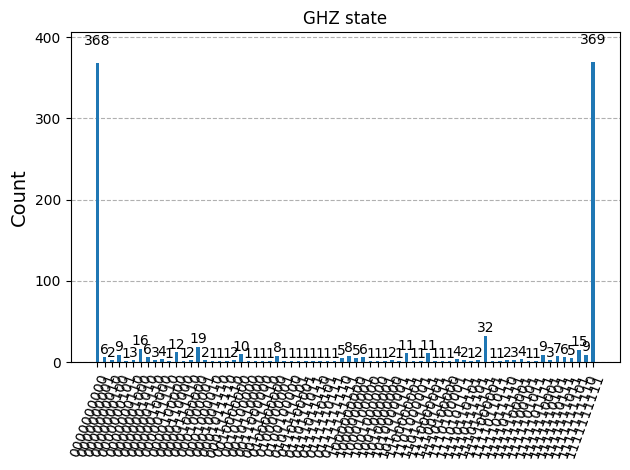

In [ ]:
counts_list = results_sampler[0].data.meas.get_counts()
print(counts_list)
print(f"  Outcomes : {counts_list}")
display(plot_histogram(counts_list, title="GHZ state"))

Layout method: trivial
Transpilation time (sec.): 0.025111675262451172
Circuit depth: 75
------------------------------------------------------------------------------------------------------------------------------------------------------
Layout method: sabre
Transpilation time (sec.): 0.01504659652709961
Circuit depth: 104
------------------------------------------------------------------------------------------------------------------------------------------------------
Layout method: dense
Transpilation time (sec.): 0.016027450561523438
Circuit depth: 128
------------------------------------------------------------------------------------------------------------------------------------------------------
Layout method: default
Transpilation time (sec.): 0.014930486679077148
Circuit depth: 79
------------------------------------------------------------------------------------------------------------------------------------------------------

Best layout method: trivial with smallest 

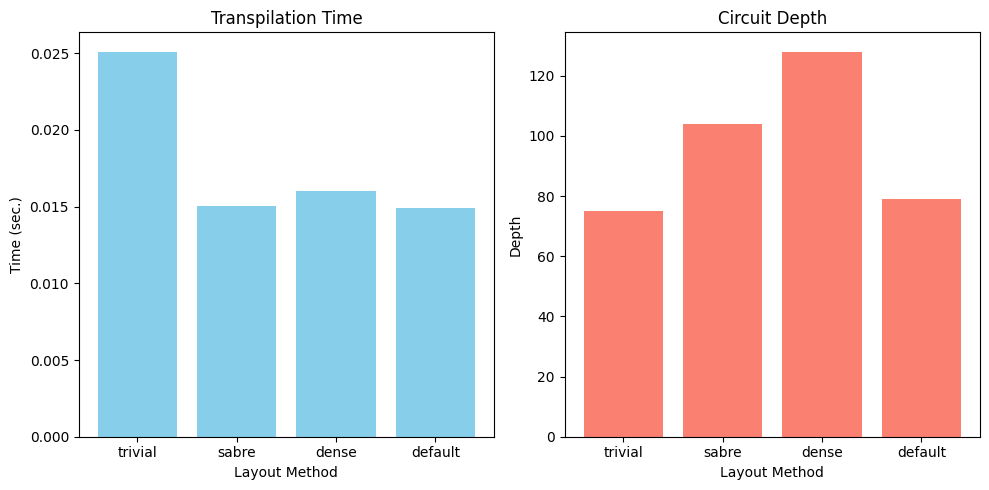

In [ ]:
times = []
depths = []
# Sweep over layout methods
### WRITE YOUR CODE HERE ###
layout_methods = ('trivial', 'sabre', 'dense', 'default')
for layout_method in layout_methods:
    pm = generate_preset_pass_manager(backend=backend, optimization_level=2, layout_method=layout_method)
    ### YOUR CODE FINISHES HERE
    print('\033[1m' + f'Layout method: {layout_method}')
    start = time.time()
    isa_qc = pm.run(qc)
    dt = time.time() - start
    times.append(dt)
    depth = isa_qc.depth()
    depths.append(depth)

    print('Transpilation time (sec.):', dt)
    print('Circuit depth:', depth)
    print('---' * 50)

# Identify the layout method with the smallest depth
min_depth_index = depths.index(min(depths))
best_layout = layout_methods[min_depth_index]
min_depth = depths[min_depth_index]

print(f"\nBest layout method: {best_layout} with smallest circuit depth of {min_depth}.")

# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(layout_methods, times, color='skyblue')
plt.title('Transpilation Time')
plt.xlabel('Layout Method')
plt.ylabel('Time (sec.)')

plt.subplot(1, 2, 2)
plt.bar(layout_methods, depths, color='salmon')
plt.title('Circuit Depth')
plt.xlabel('Layout Method')
plt.ylabel('Depth')

plt.tight_layout()
plt.show()


Optimization level: 0
Transpilation time (sec.): 0.015467166900634766
Circuit depth: 164
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 1
Transpilation time (sec.): 0.027176618576049805
Circuit depth: 90
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 2
Transpilation time (sec.): 0.025469303131103516
Circuit depth: 93
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 3
Transpilation time (sec.): 0.0446772575378418
Circuit depth: 97
------------------------------------------------------------------------------------------------------------------------------------------------------


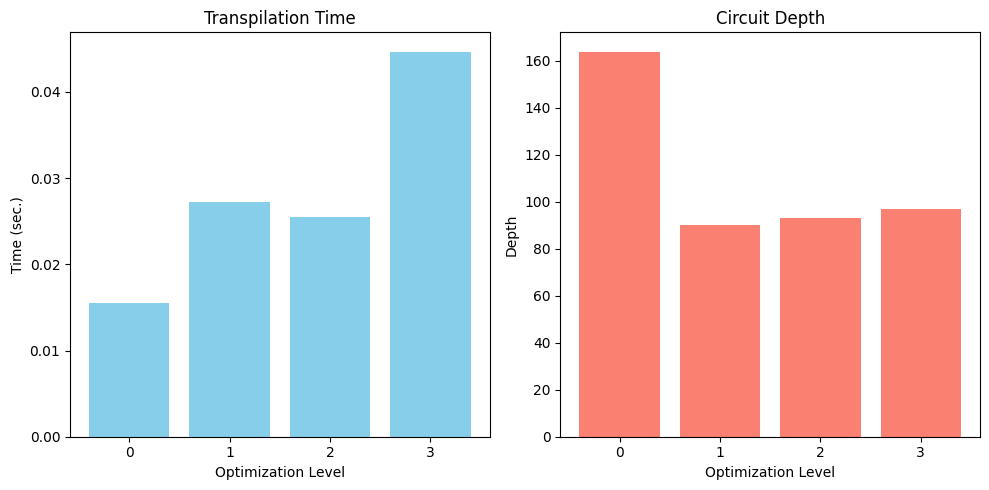

In [ ]:
times = []
depths = []
### WRITE YOUR CODE HERE ###
# Sweep over different optimization levels
optimization_levels = (0, 1, 2, 3)
for level in optimization_levels:
    pm = generate_preset_pass_manager(backend=backend, optimization_level=level, layout_method='sabre')
    ### YOUR CODE FINISHES HERE ###
    print('\033[1m' + f'Optimization level: {level}')
    start = time.time()
    isa_qc = pm.run(qc)
    dt = time.time() - start
    times.append(dt)
    depth = isa_qc.depth()
    depths.append(depth)

    print('Transpilation time (sec.):', dt)
    print('Circuit depth:', depth)
    print('---' * 50)

# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar([str(lvl) for lvl in optimization_levels], times, color='skyblue')
plt.title('Transpilation Time')
plt.xlabel('Optimization Level')
plt.ylabel('Time (sec.)')

plt.subplot(1, 2, 2)
plt.bar([str(lvl) for lvl in optimization_levels], depths, color='salmon')
plt.title('Circuit Depth')
plt.xlabel('Optimization Level')
plt.ylabel('Depth')

plt.tight_layout()
plt.show()


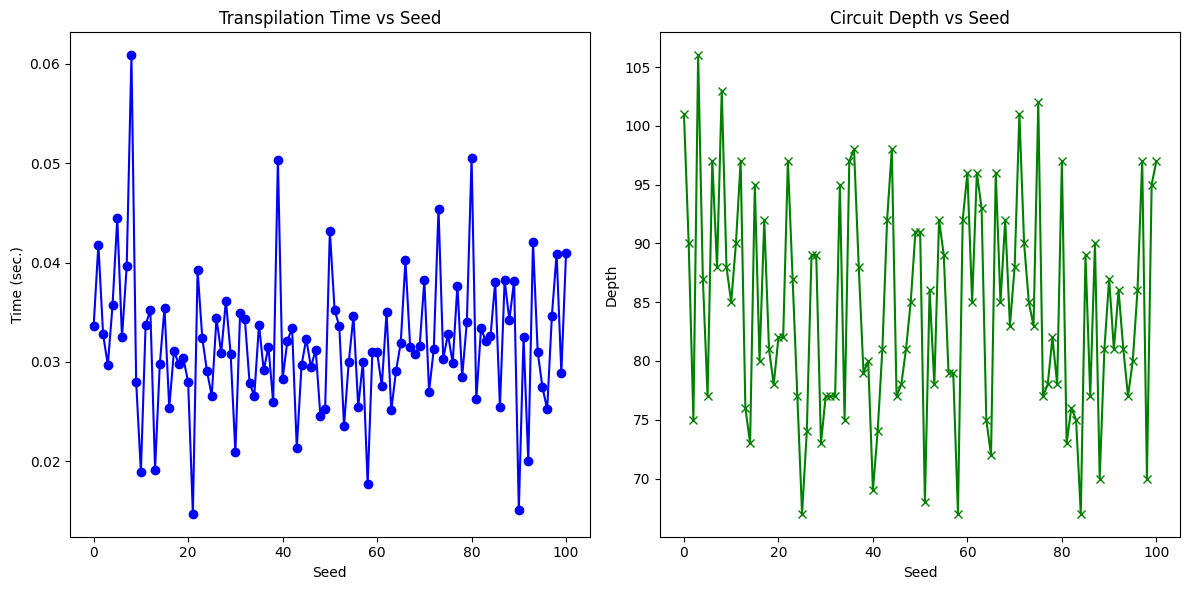

In [ ]:
times = []
depths = []
### WRITE YOUR CODE HERE ###
# Sweep over seed_transpiler values
seed_values = range(0, 101)
for seed in seed_values:
    pm = generate_preset_pass_manager(backend=backend, optimization_level=level, layout_method='sabre', seed_transpiler=seed)
    ### YOUR CODE FINISHES HERE
    start = time.time()
    isa_qc = pm.run(qc)
    dt = time.time() - start
    times.append(dt)
    depths.append(isa_qc.depth())

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(seed_values, times, marker='o', linestyle='-', color='blue')
plt.title('Transpilation Time vs Seed')
plt.xlabel('Seed')
plt.ylabel('Time (sec.)')

plt.subplot(1, 2, 2)
plt.plot(seed_values, depths, marker='x', linestyle='-', color='green')
plt.title('Circuit Depth vs Seed')
plt.xlabel('Seed')
plt.ylabel('Depth')

plt.tight_layout()
plt.show()


In [ ]:
# Find the seed with the smallest depth
min_depth_index = depths.index(min(depths))
best_seed = seed_values[min_depth_index]
min_depth = depths[min_depth_index]

print(f"The best seed is {best_seed} with the smallest circuit depth of {min_depth}.")


The best seed is 25 with the smallest circuit depth of 67.


### Run Binary Tree

In [ ]:
def binary_tree(n):
    qc = QuantumCircuit(n)
    qc.h(0)

    # Queue-basierte Breitensuche für binären Baum
    queue = [0]
    next_qubit = 1

    while next_qubit < n:
        parent = queue.pop(0)

        # Linkes Kind
        if next_qubit < n:
            qc.cx(parent, next_qubit)
            queue.append(next_qubit)
            next_qubit += 1

        # Rechtes Kind
        if next_qubit < n:
            qc.cx(parent, next_qubit)
            queue.append(next_qubit)
            next_qubit += 1

    return qc

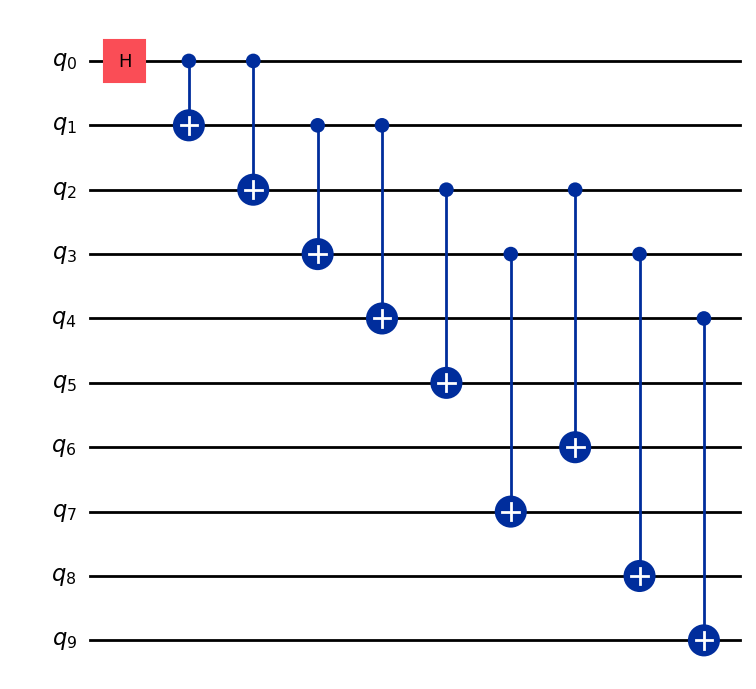

In [ ]:
qc = binary_tree(10) 
qc.draw('mpl') 

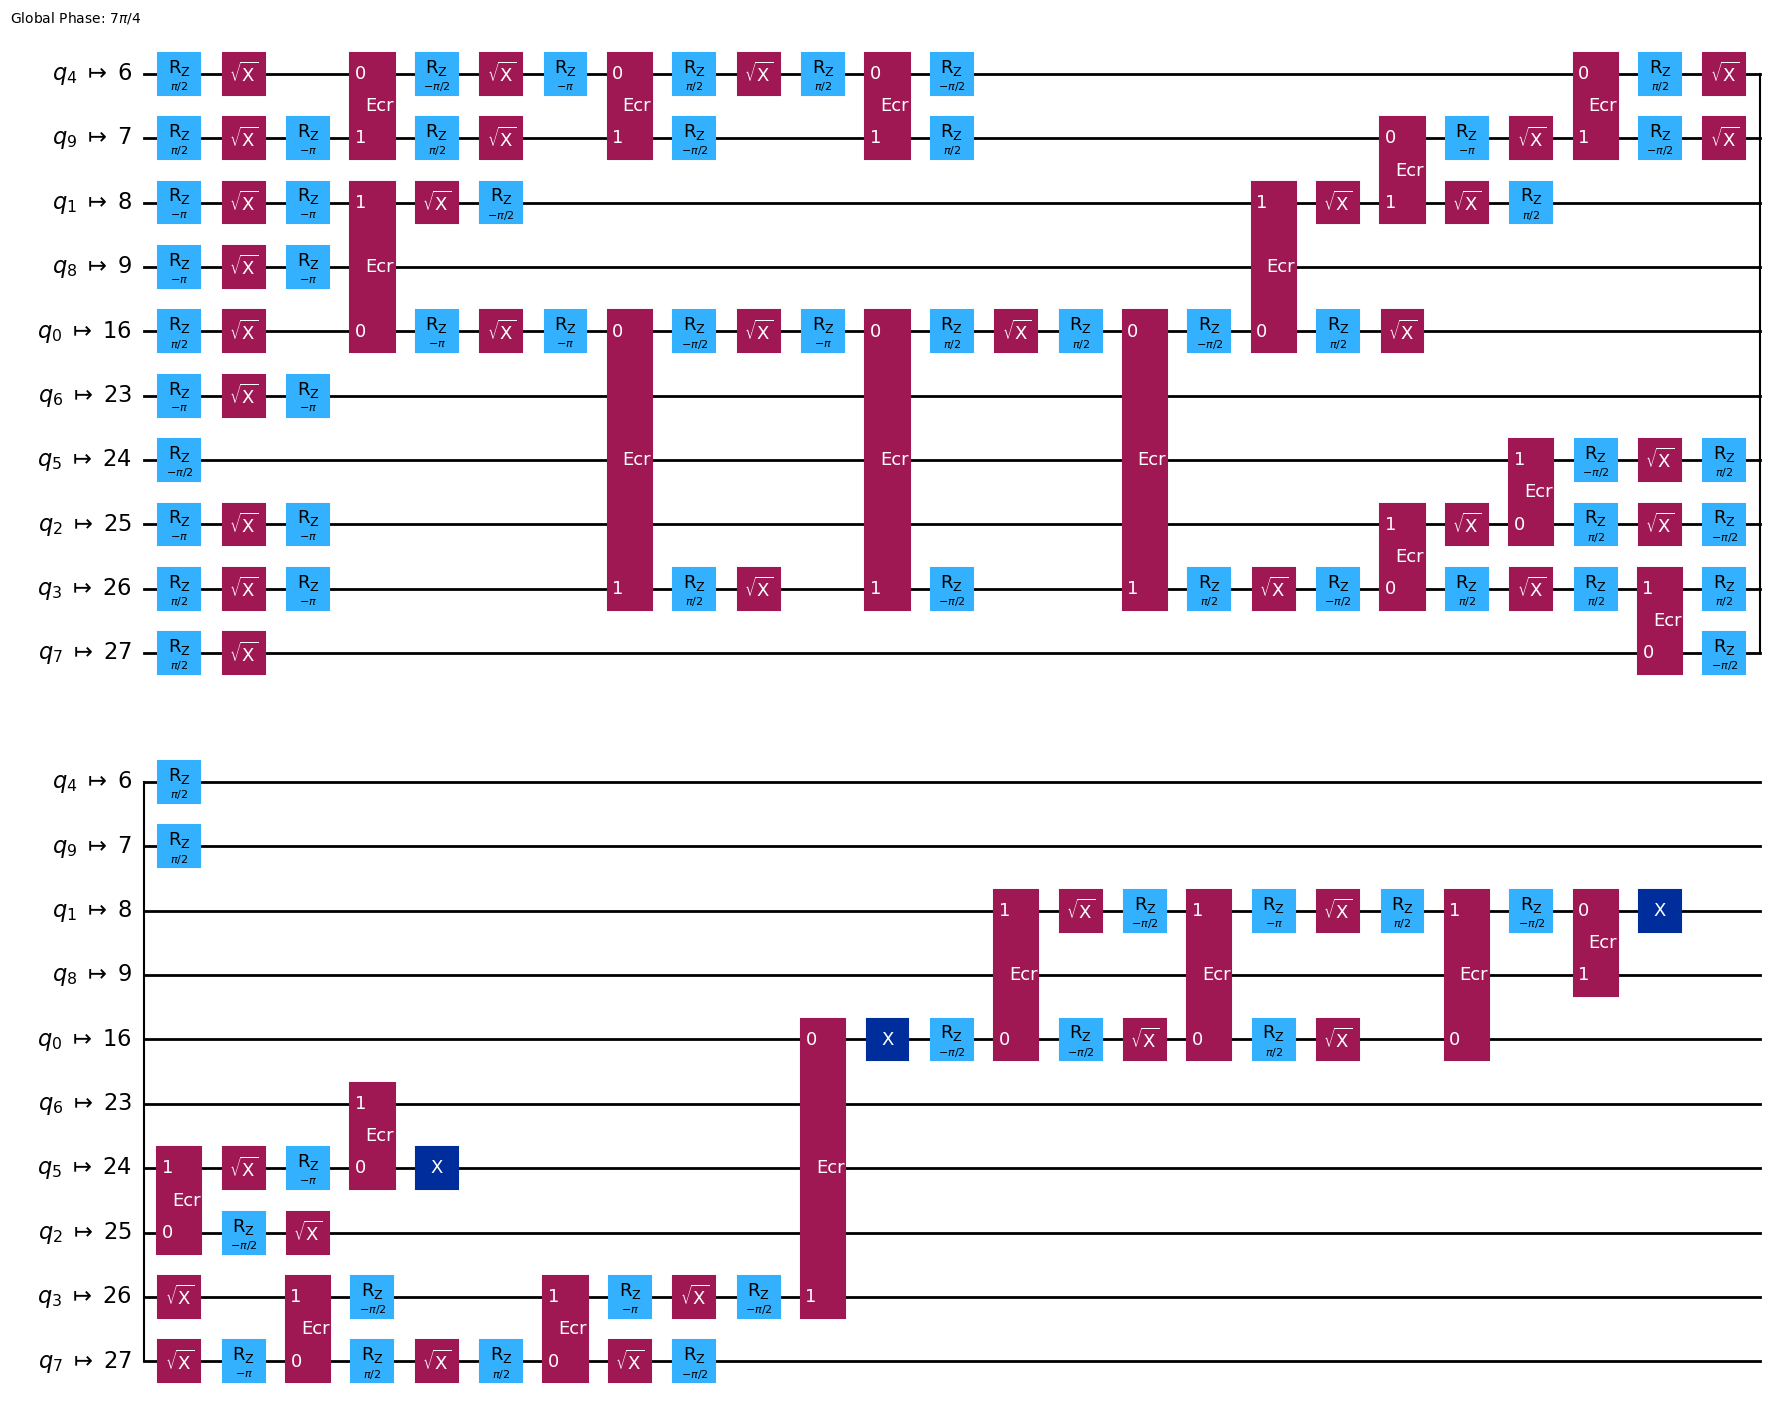

In [ ]:
# Convert to an ISA circuit and layout-mapped observables.
### WRITE YOUR CODE HERE ###

pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
isa_circuit = pm.run(qc)

### YOUR CODE FINISHES HERE ###

isa_circuit.draw("mpl", idle_wires=False)

In [ ]:
n = 10

### WRITE YOUR CODE HERE ###
# ZZII...II, ZIZI...II, ... , ZIII...IZ
observables_labels= ["Z" + "I" * i + "Z" + "I" * (n - i - 2) for i in range(n - 1)
    
]
### YOUR CODE FINISHES HERE ###

print(observables_labels)
print(len(observables_labels))

observables = [SparsePauliOp(operator) for operator in observables_labels]

['ZZIIIIIIII', 'ZIZIIIIIII', 'ZIIZIIIIII', 'ZIIIZIIIII', 'ZIIIIZIIII', 'ZIIIIIZIII', 'ZIIIIIIZII', 'ZIIIIIIIZI', 'ZIIIIIIIIZ']
9


In [ ]:
# Construct the Estimator instance.
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

In [ ]:
# One pub, with one circuit to run against six different observables.
### WRITE YOUR CODE HERE ###
job = estimator.run([(isa_circuit, mapped_observables)])
### YOUR CODE FINISHES HERE ###

# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: 58caaa79-d5b3-45ad-9305-8ed8631dc25c


c:\Users\jknem\Anaconda3\envs\qiskit_env_2\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


In [ ]:
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()

# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

In [ ]:
# We include the measurements in the circuit
qc.measure_all()
sampler = Sampler(mode=backend)

In [ ]:
### WRITE YOUR CODE HERE ###
job_sampler = sampler.run(pm.run([qc]))
### YOUR CODE FINISHES HERE ###
# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job_sampler.job_id()}")
# Get the results
results_sampler = job_sampler.result()

>>> Job ID: 7301cc57-d305-4719-af64-abd955ec2f43


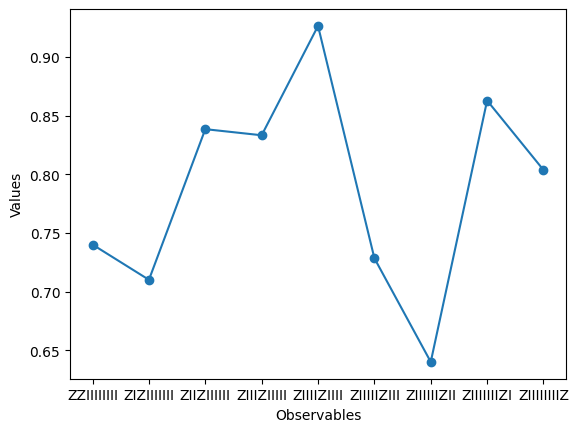

In [ ]:
# Plot the result
from matplotlib import pyplot as plt
values = pub_result.data.evs
errors = pub_result.data.stds
# plotting graph
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

{'0000000000': 376, '1111111111': 365, '1000010000': 9, '1111111110': 11, '0110101111': 1, '0111111111': 10, '0000000100': 13, '1110111111': 14, '1111011110': 1, '1000000000': 11, '1110011011': 2, '0001000000': 16, '1101111111': 11, '0101100101': 1, '0000000001': 7, '1111111011': 6, '0001000100': 3, '0010000000': 4, '1001010000': 5, '0000100001': 2, '0111101111': 10, '0100000000': 9, '1111011111': 18, '0000010000': 9, '0000100000': 7, '0000001000': 14, '0111111110': 1, '0100000100': 1, '1001110100': 2, '1111110111': 13, '1011111111': 10, '1111111101': 3, '0000000010': 3, '0110001011': 2, '0011100101': 1, '1001110111': 2, '1110110111': 2, '1111101111': 6, '1011111011': 1, '0111001111': 2, '1110001011': 1, '1110011010': 4, '0001000001': 1, '0001100101': 5, '0101000000': 2, '0111110111': 1, '1111110011': 2, '0110101110': 1, '1111010011': 1, '0011111011': 1, '1111010111': 1, '1001010001': 1, '1011111101': 1, '0101111111': 1, '0100001000': 3, '0000001100': 1, '1001000000': 1, '0000000011': 

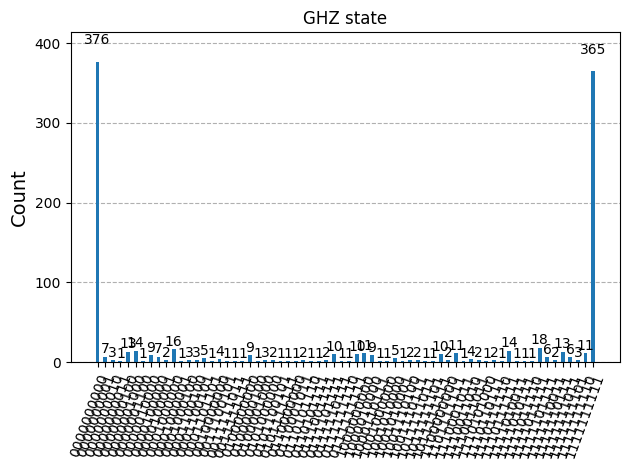

In [ ]:
counts_list = results_sampler[0].data.meas.get_counts()
print(counts_list)
print(f"  Outcomes : {counts_list}")
display(plot_histogram(counts_list, title="GHZ state"))

Layout method: trivial
Transpilation time (sec.): 0.01657724380493164
Circuit depth: 98
------------------------------------------------------------------------------------------------------------------------------------------------------
Layout method: sabre
Transpilation time (sec.): 0.008448123931884766
Circuit depth: 40
------------------------------------------------------------------------------------------------------------------------------------------------------
Layout method: dense
Transpilation time (sec.): 0.016994237899780273
Circuit depth: 90
------------------------------------------------------------------------------------------------------------------------------------------------------
Layout method: default
Transpilation time (sec.): 0.01639699935913086
Circuit depth: 56
------------------------------------------------------------------------------------------------------------------------------------------------------

Best layout method: sabre with smallest circu

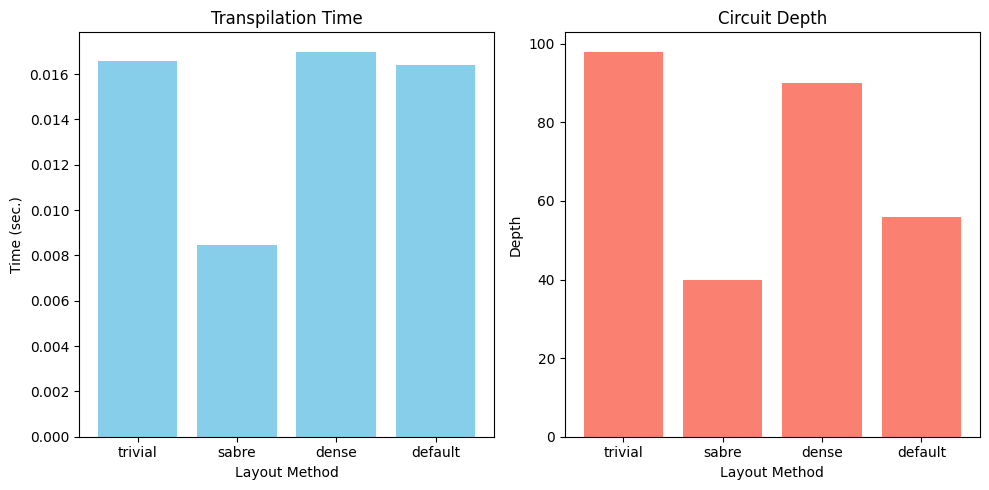

In [ ]:
times = []
depths = []
# Sweep over layout methods
### WRITE YOUR CODE HERE ###
layout_methods = ('trivial', 'sabre', 'dense', 'default')
for layout_method in layout_methods:
    pm = generate_preset_pass_manager(backend=backend, optimization_level=2, layout_method=layout_method)
    ### YOUR CODE FINISHES HERE
    print('\033[1m' + f'Layout method: {layout_method}')
    start = time.time()
    isa_qc = pm.run(qc)
    dt = time.time() - start
    times.append(dt)
    depth = isa_qc.depth()
    depths.append(depth)

    print('Transpilation time (sec.):', dt)
    print('Circuit depth:', depth)
    print('---' * 50)

# Identify the layout method with the smallest depth
min_depth_index = depths.index(min(depths))
best_layout = layout_methods[min_depth_index]
min_depth = depths[min_depth_index]

print(f"\nBest layout method: {best_layout} with smallest circuit depth of {min_depth}.")

# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(layout_methods, times, color='skyblue')
plt.title('Transpilation Time')
plt.xlabel('Layout Method')
plt.ylabel('Time (sec.)')

plt.subplot(1, 2, 2)
plt.bar(layout_methods, depths, color='salmon')
plt.title('Circuit Depth')
plt.xlabel('Layout Method')
plt.ylabel('Depth')

plt.tight_layout()
plt.show()


Optimization level: 0
Transpilation time (sec.): 0.012297630310058594
Circuit depth: 72
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 1
Transpilation time (sec.): 0.00774383544921875
Circuit depth: 32
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 2
Transpilation time (sec.): 0.01575303077697754
Circuit depth: 48
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 3
Transpilation time (sec.): 0.030386924743652344
Circuit depth: 42
------------------------------------------------------------------------------------------------------------------------------------------------------


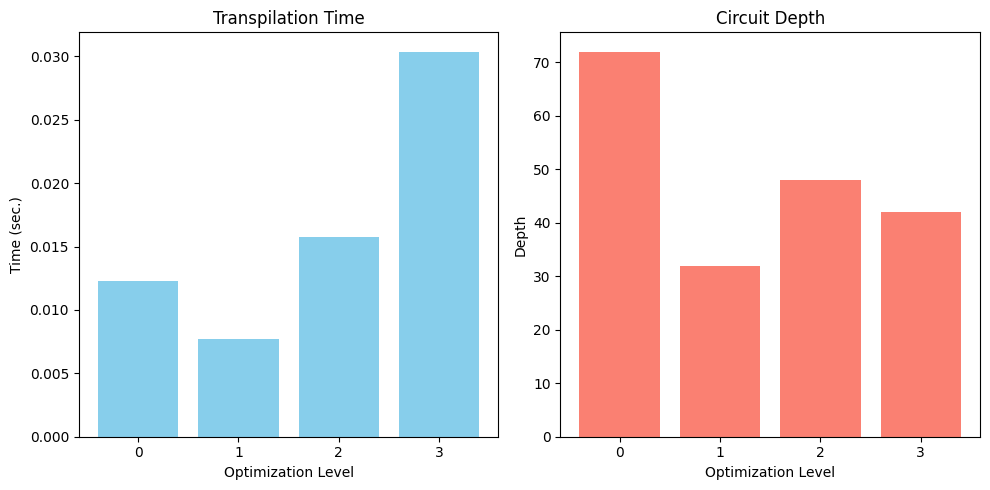

In [ ]:
times = []
depths = []
### WRITE YOUR CODE HERE ###
# Sweep over different optimization levels
optimization_levels = (0, 1, 2, 3)
for level in optimization_levels:
    pm = generate_preset_pass_manager(backend=backend, optimization_level=level, layout_method='sabre')
    ### YOUR CODE FINISHES HERE ###
    print('\033[1m' + f'Optimization level: {level}')
    start = time.time()
    isa_qc = pm.run(qc)
    dt = time.time() - start
    times.append(dt)
    depth = isa_qc.depth()
    depths.append(depth)

    print('Transpilation time (sec.):', dt)
    print('Circuit depth:', depth)
    print('---' * 50)

# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar([str(lvl) for lvl in optimization_levels], times, color='skyblue')
plt.title('Transpilation Time')
plt.xlabel('Optimization Level')
plt.ylabel('Time (sec.)')

plt.subplot(1, 2, 2)
plt.bar([str(lvl) for lvl in optimization_levels], depths, color='salmon')
plt.title('Circuit Depth')
plt.xlabel('Optimization Level')
plt.ylabel('Depth')

plt.tight_layout()
plt.show()


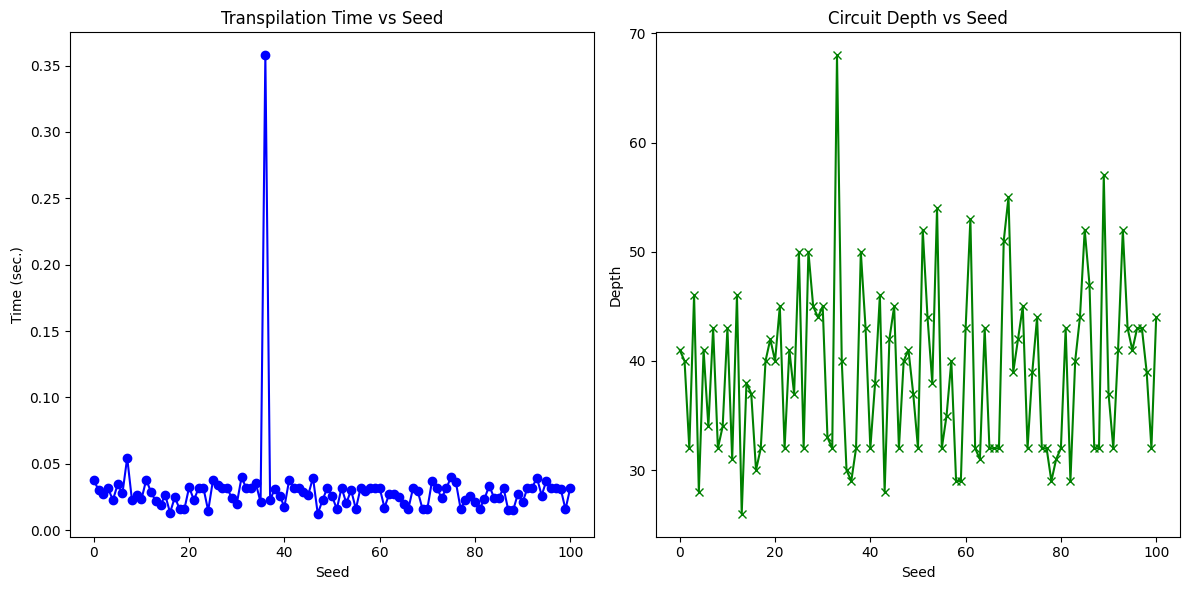

In [ ]:
times = []
depths = []
### WRITE YOUR CODE HERE ###
# Sweep over seed_transpiler values
seed_values = range(0, 101)
for seed in seed_values:
    pm = generate_preset_pass_manager(backend=backend, optimization_level=level, layout_method='sabre', seed_transpiler=seed)
    ### YOUR CODE FINISHES HERE
    start = time.time()
    isa_qc = pm.run(qc)
    dt = time.time() - start
    times.append(dt)
    depths.append(isa_qc.depth())

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(seed_values, times, marker='o', linestyle='-', color='blue')
plt.title('Transpilation Time vs Seed')
plt.xlabel('Seed')
plt.ylabel('Time (sec.)')

plt.subplot(1, 2, 2)
plt.plot(seed_values, depths, marker='x', linestyle='-', color='green')
plt.title('Circuit Depth vs Seed')
plt.xlabel('Seed')
plt.ylabel('Depth')

plt.tight_layout()
plt.show()
